# Data Loading and Configuration


In [1]:
# --- CELL 1: ENVIRONMENT SETUP ---
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import os

# VISUAL THEME: Ashesi Professional Palette
# Deep Burgundy (#881c1c), Slate Grey (#2c3e50), Gold (#f1c40f)
ASHESI_PALETTE = ['#881c1c', '#2c3e50', '#f1c40f', '#95a5a6']
sns.set_palette(sns.color_palette(ASHESI_PALETTE))
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Configuration to display all columns
pd.set_option('display.max_columns', None)

print("Analytics Engine Initialized.")

Analytics Engine Initialized.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
application_path = '/content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/Student Success at Ashesi/anon_data_v2b/anon_application_data_v2b.csv'
transcript_path = '/content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/Student Success at Ashesi/anon_data_v2b/anon_Transcript_Reports_v2.csv'
cgpa_path = '/content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/Student Success at Ashesi/anon_data_v2b/anon_CGPA_Reports_v2b.csv'
ajc_path = '/content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/additional_data-sample/anon_AJC.csv'


df_apps = pd.read_csv(application_path)
df_trans = pd.read_csv(transcript_path)
df_cgpa = pd.read_csv(cgpa_path)
df_ajc = pd.read_csv(ajc_path)

Mounted at /content/drive


/tmp/ipython-input-174427847.py:10: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trans = pd.read_csv(transcript_path)


In [3]:
# --- CELL 2: DATA LOADING AND FILTERING ---


# # Standardize ID columns
if df_trans is not None: df_trans.rename(columns={'StudentRef': 'Student_ID'}, inplace=True)
if df_cgpa is not None: df_cgpa.rename(columns={'Student Ref': 'Student_ID'}, inplace=True)

# 2. Identify Enrolled Students
# We create a set of unique IDs found in the academic records.
enrolled_ids = set(df_cgpa['Student_ID'].unique()).union(set(df_trans['Student_ID'].unique()))
print(f"Total Enrolled Students identified: {len(enrolled_ids)}")

# 3. Load and Filter Admissions Data
# df_apps = load_dataset('anon_application_data_v2b.csv')  # UNDO
if df_apps is not None:
    # Rename critical columns
    df_apps.rename(columns={
        'StudentRef': 'Student_ID',
        'Extra question: Do you Need Financial Aid?': 'Financial_Aid_Status'
    }, inplace=True)

    # FILTER: Keep only students who actually enrolled
    initial_count = len(df_apps)
    df_apps = df_apps[df_apps['Student_ID'].isin(enrolled_ids)]
    final_count = len(df_apps)

    print(f"Applicants Loaded: {initial_count}")
    print(f"Applicants Retained (Enrolled): {final_count}")
    print(f"Dropped (Unenrolled): {initial_count - final_count}")

# 4. Load Conduct Data
# df_ajc = load_dataset('anon_AJC.csv') #UNDO
if df_ajc is not None:
    df_ajc.rename(columns={'StudentRef': 'Student_ID'}, inplace=True)

Total Enrolled Students identified: 3718
Applicants Loaded: 12647
Applicants Retained (Enrolled): 2345
Dropped (Unenrolled): 10302


# EXPLORATORY DATA ANALYSIS

In [4]:
df_apps['Submitted_Date_Dt'] = pd.to_datetime(df_apps['Submitted date'], dayfirst=True, errors='coerce')
# Extract numeric Exam Year (handling "01/03/2017" vs "2017")
df_apps['Exam_Year_Clean'] = df_apps['Extra question: Exam Year'].astype(str).str.extract(r'(\d{4})').astype(float)

#--- B. Get Latest CGPA per Student ---
# We need the FINAL CGPA, not the one from their first semester.
# Map semesters to numbers for sorting
semester_map = {'Semester 1': 1, 'Semester 2': 2, 'Semester 3': 3}
df_cgpa['Sem_Num'] = df_cgpa['Semester/Year'].map(semester_map).fillna(0)

# Sort by Student -> Year (Descending) -> Semester (Descending)
cgpa_sorted = df_cgpa.sort_values(by=['Student_ID', 'Academic Year', 'Sem_Num'], ascending=[True, False, False])

# Keep only the top row for each student (their latest status)
latest_cgpa = cgpa_sorted.drop_duplicates(subset=['Student_ID'], keep='first')



# # --- C. Merge Application and CGPA ---
# # Key: StudentRef (App data) == Student Ref (CGPA data)
master_df = pd.merge(latest_cgpa, df_apps, left_on='Student_ID', right_on='Student_ID', how='inner')

print(f"Merged Dataset Created with {len(master_df)} unique students.")

Merged Dataset Created with 2345 unique students.


In [5]:
display(master_df.head())

,Yeargroup,Student_ID,Admission Year,Program,Semester/Year,Academic Year,Student Status,Gender_x,Nationality_x,Application Category,GPA,CGPA,Sem_Num,Applicant,Application,Created date,Submitted date,Offer type,Offer course name,Gender_y,Nationality_y,Disadvantaged background,Latest Education Level,Education - Block 1: Level of education,Education - Block 2: Level of education,Language: native,Extra question: Intended Major/Program of study at Ashesi University,"Extra question: Have you applied to Ashesi before? If ""yes"" indicate the year.",Extra question: Have any of your family members gained admission to Ashesi University?,Extra question: Is he/she alive?,Extra question: Relationship to you?,Extra question: Level of education,Extra question: Is he/she alive?.1,Extra question: Relationship to you?.1,Extra question: Level of education.1,Extra question: Is he/she alive?.2,Extra question: Relationship to you?.2,Extra question: Level of education.2,Extra question: Is he/she alive?.3,Extra question: Relationship to you?.3,Extra question: Level of education.3,Extra question: Type of Exam,Extra question: Exam Year,Extra question: Certificate Awarded,Extra question: Graduating/Cummulative Score,Extra question: Certificate Classification,Extra question: How did you hear about Ashesi? You can select all that apply to you:,"Extra question: Have you ever attended any Ashesi sponsored high school event? If ""yes"" please state event and year of attendance.",Financial_Aid_Status,Submitted_Date_Dt,Exam_Year_Clean
0,2026,S00039f6fd1b74390,2022-2023,B.Sc - Mechanical Engineering,Semester 2,2024-2025,Active,Male,Country0,AFA,3.90,3.80,2,26475,19429,20/03/2022 11:08,06/07/2022 15:22,Enrolled,[B.Sc.] Mechanical Engineering,M,Country0,NaN,SE,SE,SE,en,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Father,Tertiary/University Education,Yes,Mother,Tertiary/University Education,IGCSE 'A' Level\nInternational Baccalaureate (...,29/04/2022,NaN,NaN,NaN,Ashesi Student/Alumni\nAshesi Website\nTeacher...,No,Yes,2022-07-06 15:22:00,2022.0
1,2025,S0021eb5e8ac9bfec,2021-2022,B.Sc - Management Information Systems,Semester 2,2024-2025,Graduated,Female,Country0,AFA,3.50,3.35,2,18586,14429,17/03/2021 15:01,09/12/2021 15:00,Enrolled,[B.Sc.] Management Information Systems,F,Country0,NaN,SE,SE,NaN,fat,NaN,No.,No,Yes,Father,Tertiary,Yes,Father,Tertiary,NaN,NaN,NaN,NaN,NaN,NaN,WASSCE - Ghana,NaN,NaN,NaN,NaN,Ashesi Staff/Faculty,No.,Yes,2021-12-09 15:00:00,NaN
2,2028,S00364db68c4f235e,2024-2025,B.Sc - Mechanical Engineering,Semester 3,2024-2025,Active,Male,Country0,AFA,3.39,3.44,3,49270,35038,2024-04-28 18:34:41,2024-12-30 14:46:20,Enrolled,[B.Sc.] Mechanical Engineering,M,Country0,NaN,SE,SE,NaN,en,NaN,No please I haven't,No,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Father,Tertiary/University Education,Yes,Mother,Tertiary/University Education,WASSCE - Ghana,2024-08-05,NaN,NaN,NaN,Friend\nAshesi Student/Alumni\nTeacher / Couns...,NaN,Yes,NaT,2024.0
3,2025,S003e475aa47d58dc,2021-2022,B.Sc - Computer Science,Semester 2,2024-2025,Graduated,Male,Country0,AFA,2.60,3.07,2,23698,17484,18/10/2021 20:42,13/11/2021 19:02,Enrolled,[B.Sc.] Computer Science,M,Country0,NaN,SE,SE,NaN,ee,NaN,No,No,Yes,Father,Degree,Yes,Mother,Masters,NaN,NaN,NaN,NaN,NaN,NaN,WASSCE - Ghana,16/08/2021,NaN,NaN,NaN,Friend\nAshesi Website\nSchool Visit,Seminar for final year students in Presbyteria...,Yes,2021-11-13 19:02:00,2021.0
4,2023,S004a44d4ffc3ea70,2019-2020,B.Sc - Mechanical Engineering,Semester 2,2022-2023,Graduated,Female,Country5,MCF,3.38,3.39,2,6444,5746,19/12/2018 3:54,18/03/2019 13:28,Enrolled,[B.Sc.] Mechanical Engineering,F,Country5,NaN,SE,SE,NaN,bfd,NaN,No,No,Yes,Mother,Primary school,Yes,Father,Primary school,NaN,NaN,NaN,NaN,NaN,NaN,IGCSE 'A' Level,29/05/2018,NaN,NaN,NaN,Friend\nAshesi Website\nTeacher / Counselor,NaN,Yes,2019-03-18 13:28:00,2018.0


In [6]:
# Calculate Gap (Admission Year - Exam Year)
# Clean Admission Year first (e.g., "2013-2014" -> 2013)
master_df['Admin_Year_Int'] = master_df['Admission Year'].str.split('-').str[0].astype(float)
master_df['Gap_Years'] = master_df['Admin_Year_Int'] - master_df['Exam_Year_Clean']

/tmp/ipython-input-2289943253.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], x='Fin_Aid_Status', y='CGPA', data=master_df, palette='Blues')
/tmp/ipython-input-2289943253.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], x='Extra question: Type of Exam', y='CGPA', data=exam_data, palette='viridis')


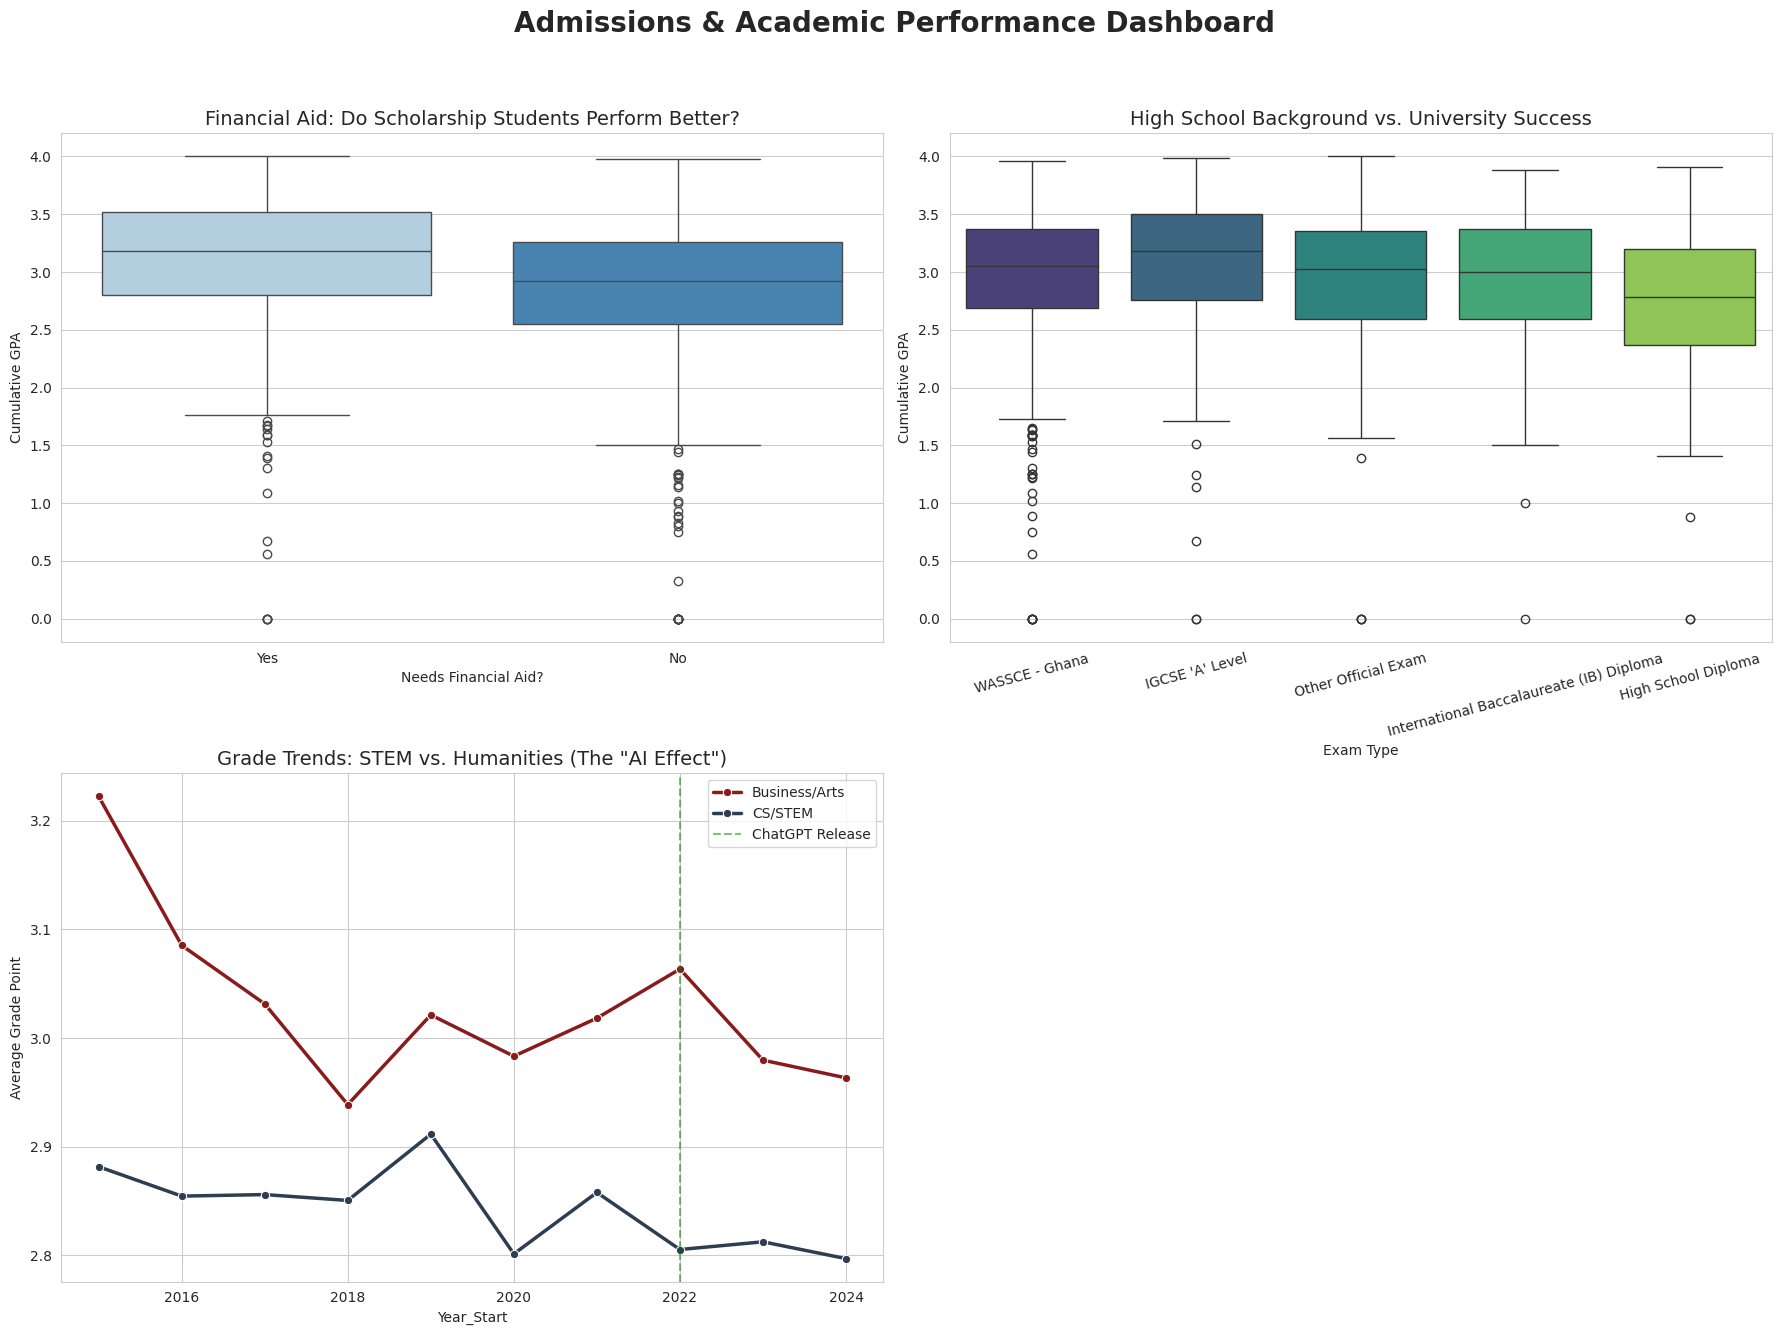

In [7]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

# Create a 2x2 Grid of Plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Admissions & Academic Performance Dashboard', fontsize=20, weight='bold')

# --- Graph 1: CGPA by Financial Aid Status (Top Left) ---
master_df['Fin_Aid_Status'] = master_df['Financial_Aid_Status'].fillna('Unknown')

sns.boxplot(ax=axes[0, 0], x='Fin_Aid_Status', y='CGPA', data=master_df, palette='Blues')
axes[0, 0].set_title('Financial Aid: Do Scholarship Students Perform Better?', fontsize=14)
axes[0, 0].set_xlabel('Needs Financial Aid?')
axes[0, 0].set_ylabel('Cumulative GPA')

# --- Graph 2: CGPA by High School Curriculum (Top Right) ---
top_exams = master_df['Extra question: Type of Exam'].value_counts().nlargest(5).index
exam_data = master_df[master_df['Extra question: Type of Exam'].isin(top_exams)]

sns.boxplot(ax=axes[0, 1], x='Extra question: Type of Exam', y='CGPA', data=exam_data, palette='viridis')
axes[0, 1].set_title('High School Background vs. University Success', fontsize=14)
axes[0, 1].set_xlabel('Exam Type')
axes[0, 1].set_ylabel('Cumulative GPA')
axes[0, 1].tick_params(axis='x', rotation=15)

# --- Graph 3: Grade Trends by Course Type (Bottom Left) ---
def classify_course(code):
    code = str(code).upper()
    if code.startswith(('MATH', 'CS', 'COMP', 'PHYS')): return 'CS/STEM'
    if code.startswith(('ENGL', 'BUSA', 'SOC', 'POLS', 'ASH', 'EXT', 'BUEC', 'ECON', 'MGT')): return 'Business/Arts'
    return 'Other'

df_trans['Course_Type'] = df_trans['Course Code'].apply(classify_course)
df_trans['Year_Start'] = pd.to_numeric(df_trans['Academic Year'].astype(str).str.split('-').str[0], errors='coerce')
df_trans['Grade point'] = pd.to_numeric(df_trans['Grade point'], errors='coerce')

# Filter for recent years and valid types
trend_data = df_trans[df_trans['Year_Start'] >= 2015]
trend_data = trend_data[trend_data['Course_Type'] != 'Other']
trend_agg = trend_data.groupby(['Year_Start', 'Course_Type'])['Grade point'].mean().reset_index()

sns.lineplot(ax=axes[1, 0], x='Year_Start', y='Grade point', hue='Course_Type', data=trend_agg, marker='o', linewidth=2.5)
axes[1, 0].set_title('Grade Trends: STEM vs. Humanities (The "AI Effect")', fontsize=14)
axes[1, 0].set_ylabel('Average Grade Point')
axes[1, 0].axvline(x=2022, color='green', linestyle='--', alpha=0.5, label='ChatGPT Release')
axes[1, 0].legend()

# --- THE FIX: Remove the Empty 4th Plot ---
fig.delaxes(axes[1, 1])

# Final Adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
# Categorize the Gap
def categorize_gap(years):
    if pd.isna(years) or years < 0: return 'Unknown/Error'
    if years <= 1: return 'Direct Entry'
    if years <= 3: return 'Gap (1-3 Years)'
    return 'Mature/Long Gap (>3 Years)'

master_df['Entry_Type'] = master_df['Gap_Years'].apply(categorize_gap)

/tmp/ipython-input-3635640928.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Entry_Type', y='CGPA', data=gap_data,


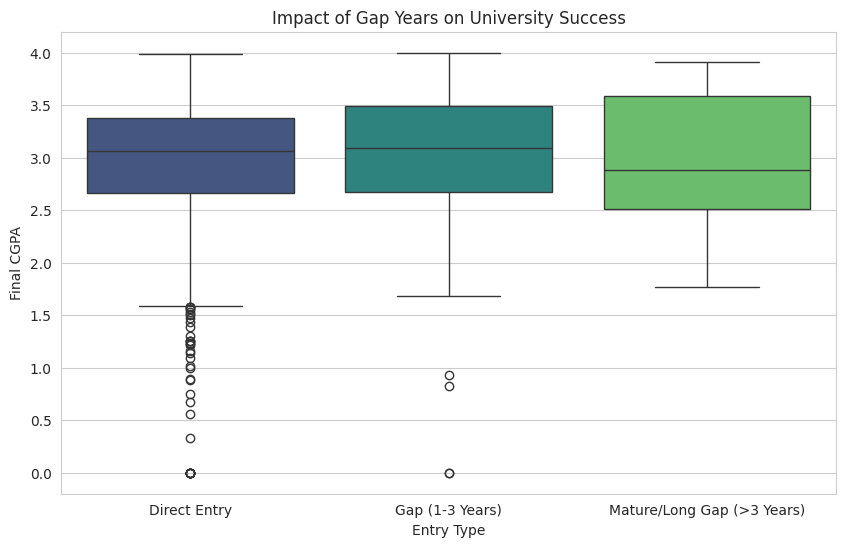

Entry_Type
Direct Entry                  2.982855
Gap (1-3 Years)               3.031071
Mature/Long Gap (>3 Years)    2.961250
Name: CGPA, dtype: float64


In [9]:
# Filter out errors
gap_data = master_df[master_df['Entry_Type'] != 'Unknown/Error']

# --- Graphing ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='Entry_Type', y='CGPA', data=gap_data,
            order=['Direct Entry', 'Gap (1-3 Years)', 'Mature/Long Gap (>3 Years)'],
            palette='viridis')
plt.title('Impact of Gap Years on University Success')
plt.ylabel('Final CGPA')
plt.xlabel('Entry Type')
plt.show()

# Print stats
print(gap_data.groupby('Entry_Type')['CGPA'].mean())

/tmp/ipython-input-1353206779.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average_GPA', y='Course Name', data=hardest_courses, palette='magma')


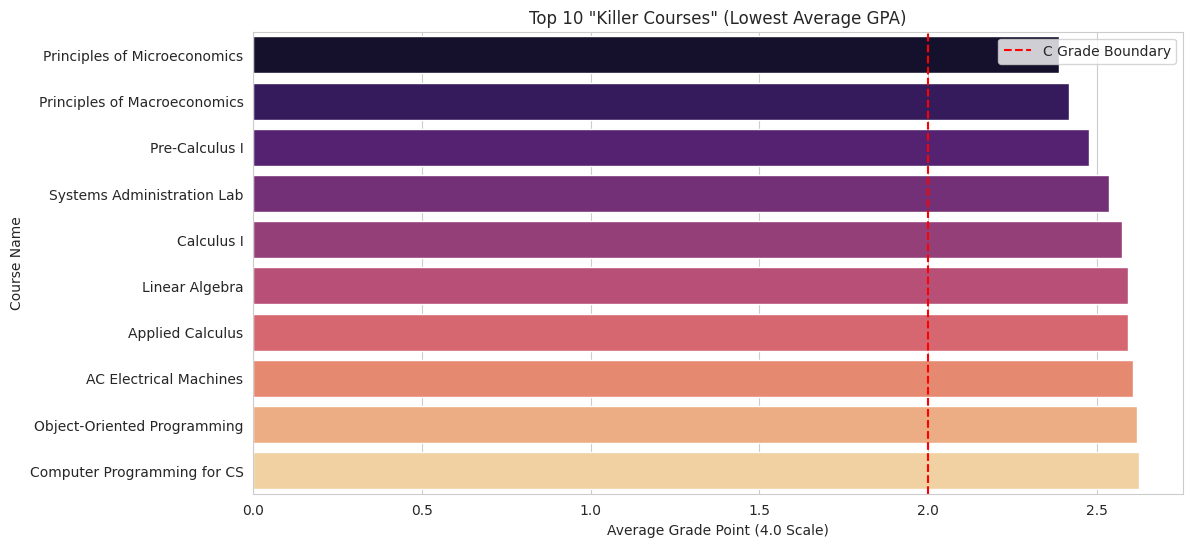

In [10]:
# Filter for valid numeric grades
valid_grades = df_trans.dropna(subset=['Grade point'])

# Calculate Stats per Course
course_stats = valid_grades.groupby(['Course Name']).agg(
    Average_GPA=('Grade point', 'mean'),
    Student_Count=('Student_ID', 'nunique'),
    Fail_Count=('Grade', lambda x: x.isin(['E', 'F']).sum())
).reset_index()

# Filter: Only look at courses with > 50 students
popular_courses = course_stats[course_stats['Student_Count'] > 50].copy()

# --- THE FIX: Remove specific courses ---
# We use str.contains so it catches variations (e.g., "Ashesi Success I" or "Giving Voice to Values II")
exclusions = ['Ashesi Success', 'Giving Voice to Values']
# This creates a pattern like "Ashesi Success|Giving Voice to Values"
pattern = '|'.join(exclusions)

# Filter them out (The '~' means NOT)
popular_courses = popular_courses[~popular_courses['Course Name'].str.contains(pattern, case=False, na=False)]

# Sort by Difficulty
hardest_courses = popular_courses.sort_values(by='Average_GPA').head(10)

# --- Graphing ---
plt.figure(figsize=(12, 6))
sns.barplot(x='Average_GPA', y='Course Name', data=hardest_courses, palette='magma')
plt.title('Top 10 "Killer Courses" (Lowest Average GPA)')
plt.xlabel('Average Grade Point (4.0 Scale)')
plt.axvline(x=2.0, color='r', linestyle='--', label='C Grade Boundary')
plt.legend()
plt.show()

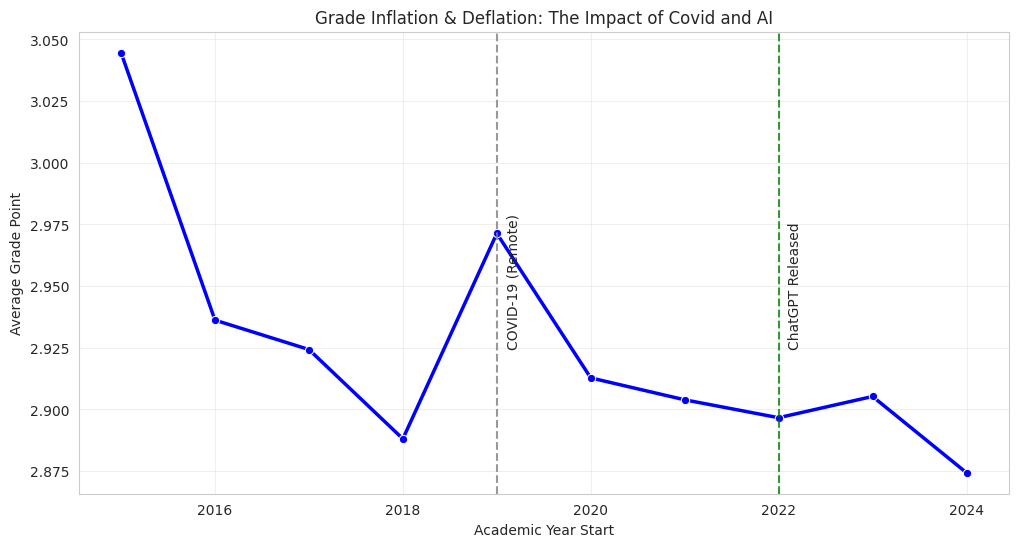

In [11]:
# Extract Year from Transcript Data
df_trans['Year_Start'] = df_trans['Academic Year'].str.split('-').str[0]
df_trans['Year_Start'] = pd.to_numeric(df_trans['Year_Start'], errors='coerce')

# Filter for recent history
trend_data = df_trans[(df_trans['Year_Start'] >= 2015) & (df_trans['Year_Start'] <= 2024)]

# Calculate Annual GPA
annual_gpa = trend_data.groupby('Year_Start')['Grade point'].mean().reset_index()

# --- Graphing ---
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year_Start', y='Grade point', data=annual_gpa, marker='o', linewidth=2.5, color='blue')

# Add Event Annotations
plt.axvline(x=2019, color='gray', linestyle='--', alpha=0.8)
plt.text(2019.1, annual_gpa['Grade point'].mean(), 'COVID-19 (Remote)', rotation=90)

plt.axvline(x=2022, color='green', linestyle='--', alpha=0.8)
plt.text(2022.1, annual_gpa['Grade point'].mean(), 'ChatGPT Released', rotation=90)

plt.title('Grade Inflation & Deflation: The Impact of Covid and AI')
plt.xlabel('Academic Year Start')
plt.ylabel('Average Grade Point')
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipython-input-2707450403.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ajc['Date_parsed'] = pd.to_datetime(df_ajc['Date'], errors='coerce')
/tmp/ipython-input-2707450403.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=misconduct_counts.index, y=misconduct_counts.values, ax=axes[0, 0], palette='Reds_r')
/tmp/ipython-input-2707450403.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=sanctions.index, x=sanctions.values, ax=axes[1, 0], palette='Oranges_r')


Academic Judicial Committee (AJC) Analysis

Total AJC Records: 143
Unique students with AJC records: 134
Percentage of students with AJC records: 6.15%


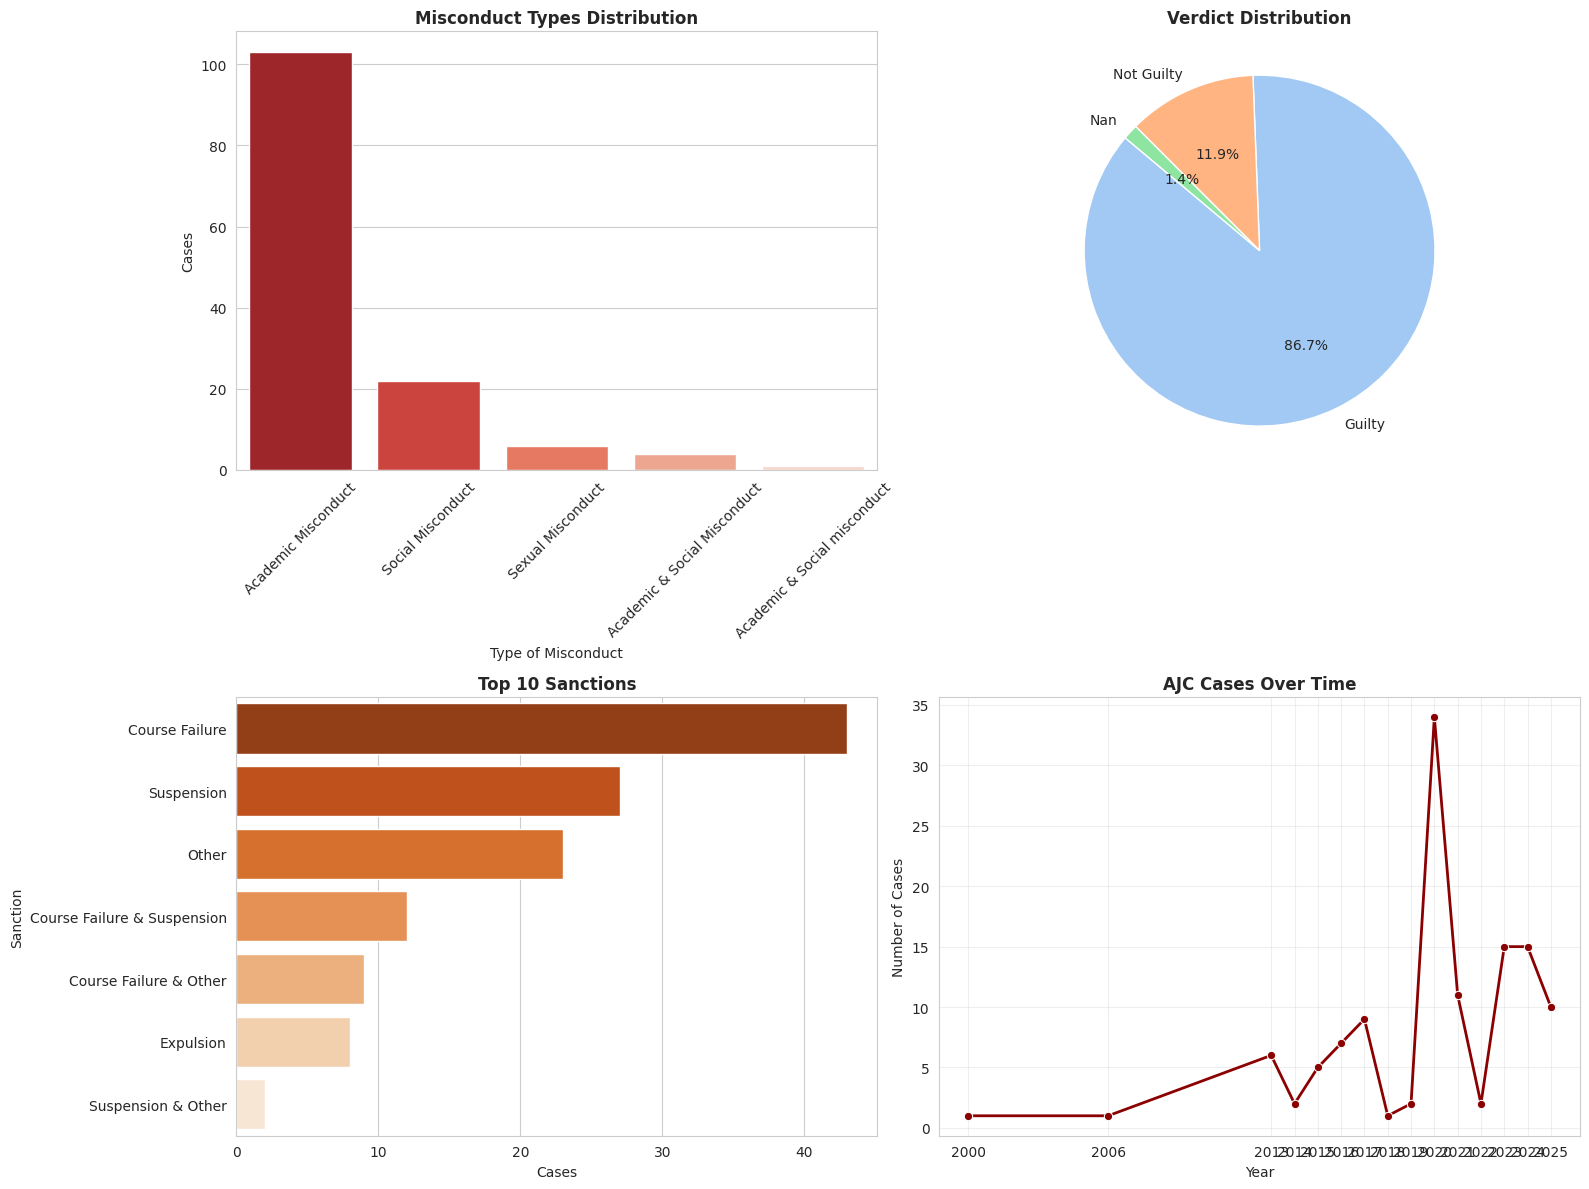

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ============================================================================
# 1. CLEAN AJC DATA (The Fixes)
# ============================================================================
# Ensure we are using the right column names
if 'StudentRef' in df_ajc.columns:
    df_ajc = df_ajc.rename(columns={'StudentRef': 'Student_ID'})

# FIX 1: Normalize "Verdict" (Title Case)
# This turns "not guilty", "Not Guilty", "NOT GUILTY" -> "Not Guilty"
if 'Verdict' in df_ajc.columns:
    df_ajc['Verdict'] = df_ajc['Verdict'].astype(str).str.strip().str.title()
    # Optional: Group 'Guilty' variants if needed (e.g. "Guilty (Major)" -> "Guilty")
    # df_ajc['Verdict'] = df_ajc['Verdict'].replace({'Guilty (Major)': 'Guilty'})

# FIX 2: Parse Dates (Fixes the missing 4th plot)
# We try to convert the 'Date' column to datetime.
# errors='coerce' turns bad dates into NaT so the code doesn't crash.
if 'Date' in df_ajc.columns:
    df_ajc['Date_parsed'] = pd.to_datetime(df_ajc['Date'], errors='coerce')
    # If standard parsing fails, sometimes date is just a Year (e.g. 2022)
    # We fill missing dates using 'Academic Year' if the date failed
    mask_missing = df_ajc['Date_parsed'].isna()
    if 'Academic Year' in df_ajc.columns:
        # Extract year from "2022-2023" -> 2022
        extracted_year = pd.to_numeric(df_ajc.loc[mask_missing, 'Academic Year'].str.split('-').str[0], errors='coerce')
        df_ajc.loc[mask_missing, 'Year'] = extracted_year

    # Create a 'Year' column for the plot
    df_ajc['Year'] = df_ajc['Date_parsed'].dt.year.fillna(df_ajc.get('Year'))

# ============================================================================
# 2. UPDATE MASTER DATAFRAME FLAGS
# ============================================================================
# Re-calculate the flag to be sure it matches the cleaned data
ajc_student_ids = set(df_ajc['Student_ID'].unique())
master_df['Has_AJC_Record'] = master_df['Student_ID'].isin(ajc_student_ids)

# ============================================================================
# 3. ANALYSIS & VISUALIZATION
# ============================================================================
print("Academic Judicial Committee (AJC) Analysis")
print("="*80)

# Overall Statistics
print(f"\nTotal AJC Records: {len(df_ajc)}")
print(f"Unique students with AJC records: {df_ajc['Student_ID'].nunique()}")
print(f"Percentage of students with AJC records: {df_ajc['Student_ID'].nunique() / master_df['Student_ID'].nunique() * 100:.2f}%")

# Create Plot Grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4) # Add space between rows

# Plot A: Misconduct Types
if 'Type of Misconduct' in df_ajc.columns:
    misconduct_counts = df_ajc['Type of Misconduct'].value_counts()
    sns.barplot(x=misconduct_counts.index, y=misconduct_counts.values, ax=axes[0, 0], palette='Reds_r')
    axes[0, 0].set_title('Misconduct Types Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].set_ylabel('Cases')

# Plot B: Verdicts (Now Cleaned!)
if 'Verdict' in df_ajc.columns:
    verdicts = df_ajc['Verdict'].value_counts()
    axes[0, 1].pie(verdicts, labels=verdicts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    axes[0, 1].set_title('Verdict Distribution', fontsize=12, fontweight='bold')

# Plot C: Sanctions
if 'Sanction' in df_ajc.columns:
    sanctions = df_ajc['Sanction'].value_counts().head(10)
    sns.barplot(y=sanctions.index, x=sanctions.values, ax=axes[1, 0], palette='Oranges_r')
    axes[1, 0].set_title('Top 10 Sanctions', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Cases')

# Plot D: Cases Over Time (Now using the fixed Year column)
if 'Year' in df_ajc.columns:
    # Drop NaNs and convert to int for cleaner x-axis
    year_counts = df_ajc['Year'].dropna().astype(int).value_counts().sort_index()
    sns.lineplot(x=year_counts.index, y=year_counts.values, ax=axes[1, 1], marker='o', color='darkred', linewidth=2)
    axes[1, 1].set_title('AJC Cases Over Time', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Cases')
    axes[1, 1].grid(True, alpha=0.3)
    # Force integer ticks on x-axis
    axes[1, 1].set_xticks(year_counts.index)

plt.tight_layout()
plt.show()

# ============================================================================
# 4. IMPACT ANALYSIS (CGPA)
# ============================================================================
if 'Has_AJC_Record' in master_df.columns and 'Final_CGPA' in master_df.columns: # Changed CGPA to Final_CGPA
    # Filter for valid CGPAs
    valid_cgpa = master_df.dropna(subset=['Final_CGPA'])

    # Separate groups
    group_no_ajc = valid_cgpa[valid_cgpa['Has_AJC_Record'] == False]['Final_CGPA']
    group_ajc = valid_cgpa[valid_cgpa['Has_AJC_Record'] == True]['Final_CGPA']

    print("\n--- Impact on Academic Performance ---")
    print(f"Average CGPA (No Record): {group_no_ajc.mean():.2f}")
    print(f"Average CGPA (Has Record): {group_ajc.mean():.2f}")

    # T-Test
    t_stat, p_val = stats.ttest_ind(group_no_ajc, group_ajc, equal_var=False)
    print(f"T-Test Result: p-value = {p_val:.5f}")
    if p_val < 0.05:
        print("CONCLUSION: There is a statistically significant drop in grades for students with misconduct records.")
    else:
        print("CONCLUSION: No significant difference in grades found.")

#Feature Engineering

In [13]:
# --- CELL 3: ADVANCED RUBRIC & SCORING LOGIC (ROBUST FIX) ---

def calculate_unified_grade_score(grade, system):
    """
    Universal Converter: Handles Numbers (0-100), GPA (0-4.0), and Letter Grades (A1-F9).
    """
    if pd.isna(grade): return 0

    # Clean input
    g = str(grade).strip().upper()
    sys = str(system).upper()

    # --- STRATEGY 1: IS IT ALREADY A NUMBER? ---
    try:
        score = float(g)

        # Scenario A: It's a Percentage (e.g., 75, 92.5) -> Scale to 0-10
        if score > 10:
            return (score / 100) * 10

        # Scenario B: It's already on 0-10 scale (e.g., 7.5) -> Keep it
        if score > 4.0 and score <= 10:
            return score

        # Scenario C: It's a GPA (0.0 - 4.0) -> Scale to 10
        if score <= 4.0:
            return (score / 4.0) * 10

    except:
        pass # Not a number, move to letter grades logic

    # --- STRATEGY 2: LETTER GRADES ---

    # WASSCE / SSSCE (A1 is Best)
    if any(x in sys for x in ['WASSCE', 'SSSCE', 'WAEC', 'GHANA', 'NIGERIA']):
        mapping = {
            'A1': 10, 'B2': 9, 'B3': 8, 'C4': 7,
            'C5': 6, 'C6': 5, 'D7': 4, 'E8': 2, 'F9': 0
        }
        return mapping.get(g, 0)

    # Cambridge / IGCSE / A-Level (A* is Best)
    if any(x in sys for x in ['IGCSE', 'LEVEL', 'CAMBRIDGE']):
        mapping = {
            'A*': 10, 'A': 9, 'B': 8, 'C': 7,
            'D': 5, 'E': 3, 'F': 1
        }
        return mapping.get(g, 0)

    # IB (International Baccalaureate)
    if 'IB' in sys:
         # IB is usually 1-7 numeric, but sometimes logged as text
         try:
             s = float(g)
             return (s / 7) * 10
         except: return 0

    return 0

# Helper to average specific subjects
def get_subject_average(row, columns, keywords):
    valid_scores = []
    for col in columns:
        # Check if column matches keyword (e.g., "PHYS")
        if any(k in col.upper() for k in keywords):
            score = row[col]
            if score > 0: valid_scores.append(score)

    if not valid_scores: return 0
    return sum(valid_scores) / len(valid_scores)

def identify_track(group):
    courses = set(group['Course Code'].unique())
    if any(c in courses for c in ['MATH100', 'MATH101']): return 'College Algebra'
    elif any(c in courses for c in ['MATH121', 'MATH122']): return 'Pre-Calculus'
    elif any(c in courses for c in ['MATH141', 'MATH142', 'MATH161']): return 'Calculus'
    return 'Unknown'

print(" Robust Grading Logic Loaded (Accepts Raw Numbers & Letters).")

 Robust Grading Logic Loaded (Accepts Raw Numbers & Letters).


In [14]:
# --- CELL 4: MASTER DATASET GENERATION (GAP YEAR & NaN FIX) ---
BASE_PATH = '/content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/additional_data_for_final_prosit'

print("Initiating Advanced Feature Engineering...")

# 1. ESTABLISH UNIQUE STUDENT BASE & ADMISSIONS DATA
unique_enrolled_ids = df_cgpa['Student_ID'].unique()

# Load Application Data
master_df = df_apps[df_apps['Student_ID'].isin(unique_enrolled_ids)].sort_values('Application').groupby('Student_ID').last().reset_index()

# FIX A: Parse HS Exam Year from Date String
if 'Extra question: Exam Year' in master_df.columns:
    master_df['HS_Exam_Year'] = pd.to_datetime(master_df['Extra question: Exam Year'], dayfirst=True, errors='coerce').dt.year
else:
    master_df['HS_Exam_Year'] = np.nan

master_df = master_df[['Student_ID', 'Gender', 'Nationality', 'Offer course name', 'Financial_Aid_Status', 'HS_Exam_Year']].copy()
master_df['Admissions_Major'] = master_df['Offer course name'].str.replace(r'\[B\.Sc\.\] |\[LLB\] ', '', regex=True).str.strip()

# 2. PROCESS ALL HIGH SCHOOL FILES (Subject Specificity)
hs_features = []

hs_files_map = {
    BASE_PATH +'/WASSCE_C2023-C2028-anon.csv': 'WASSCE',
    BASE_PATH +'/IB_C2023-C2028-anon.csv': 'IB',
    BASE_PATH +'/O&A_Level_C2023-C2028-anon.csv': 'LEVEL',
    BASE_PATH +'/FrenchBacc_C2023-C2028-anon.csv': 'FRENCH',
    BASE_PATH +'/HSDiploma_C2023-C2028-anon.csv': 'DIPLOMA',
    BASE_PATH +'/Other_C2023-C2028-anon.csv': 'LEVEL'
}
print("   > Extracting Granular Subject Data...")

for filename, system in hs_files_map.items():

    if os.path.exists(filename):
        df_temp = pd.read_csv(filename)
        df_temp.rename(columns={'StudentRef': 'Student_ID'}, inplace=True)

        meta_cols = ['Student_ID', 'Exam Type', 'Exam Year', 'Student Name', 'Index Number']
        subject_cols = [c for c in df_temp.columns if c not in meta_cols and 'YEAR' not in c.upper()]

        calc_df = df_temp[['Student_ID']].copy()

        for col in subject_cols:
            calc_df[col] = df_temp[col].apply(lambda x: calculate_unified_grade_score(x, system))

        calc_df['HS_STEM_Score'] = calc_df.apply(lambda r: get_subject_average(r, subject_cols, ['PHYS', 'CHEM', 'BIO', 'SCI', 'COMP']), axis=1)
        calc_df['HS_Math_Score'] = calc_df.apply(lambda r: get_subject_average(r, subject_cols, ['MATH', 'CALC', 'FURTHER']), axis=1)
        calc_df['HS_Business_Score'] = calc_df.apply(lambda r: get_subject_average(r, subject_cols, ['ECON', 'ACC', 'BUS', 'FIN', 'MKT']), axis=1)
        calc_df['HS_Humanities_Score'] = calc_df.apply(lambda r: get_subject_average(r, subject_cols, ['ENG', 'LIT', 'HIST', 'GOV', 'ART', 'SOC']), axis=1)

        calc_df = calc_df[calc_df['Student_ID'].isin(master_df['Student_ID'])]
        hs_features.append(calc_df[['Student_ID', 'HS_Math_Score', 'HS_STEM_Score', 'HS_Business_Score', 'HS_Humanities_Score']])
        print(f"     - Processed {len(calc_df)} records from {filename}")

if hs_features:
    df_hs_final = pd.concat(hs_features).groupby('Student_ID').max().reset_index()
    master_df = master_df.merge(df_hs_final, on='Student_ID', how='left')
    for col in ['HS_Math_Score', 'HS_STEM_Score', 'HS_Business_Score', 'HS_Humanities_Score']:
        master_df[col] = master_df[col].fillna(master_df[col].median())
else:
    print("No High School files found!")



Initiating Advanced Feature Engineering...
   > Extracting Granular Subject Data...
     - Processed 1136 records from /content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/additional_data_for_final_prosit/WASSCE_C2023-C2028-anon.csv


/tmp/ipython-input-612917208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_df[col] = df_temp[col].apply(lambda x: calculate_unified_grade_score(x, system))
/tmp/ipython-input-612917208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_df[col] = df_temp[col].apply(lambda x: calculate_unified_grade_score(x, system))
/tmp/ipython-input-612917208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

     - Processed 120 records from /content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/additional_data_for_final_prosit/IB_C2023-C2028-anon.csv


/tmp/ipython-input-612917208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_df[col] = df_temp[col].apply(lambda x: calculate_unified_grade_score(x, system))
/tmp/ipython-input-612917208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_df[col] = df_temp[col].apply(lambda x: calculate_unified_grade_score(x, system))
/tmp/ipython-input-612917208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

     - Processed 20 records from /content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/additional_data_for_final_prosit/FrenchBacc_C2023-C2028-anon.csv


/tmp/ipython-input-612917208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_df[col] = df_temp[col].apply(lambda x: calculate_unified_grade_score(x, system))
/tmp/ipython-input-612917208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  calc_df[col] = df_temp[col].apply(lambda x: calculate_unified_grade_score(x, system))
/tmp/ipython-input-612917208.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

     - Processed 45 records from /content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/additional_data_for_final_prosit/HSDiploma_C2023-C2028-anon.csv
     - Processed 132 records from /content/drive/MyDrive/MSc ICS/Graduate_ML DS/Final Project Documents/additional_data_for_final_prosit/Other_C2023-C2028-anon.csv


In [15]:


# 3. IDENTIFY MATH TRACKS
track_df = df_trans.groupby('Student_ID').apply(identify_track).reset_index(name='Math_Track')
master_df = master_df.merge(track_df, on='Student_ID', how='left')

# 4. ACADEMIC METRICS & GAP YEAR CALCULATION
trans_meta = df_trans[['Student_ID', 'Admission Year']].drop_duplicates(subset='Student_ID')

def extract_year_simple(val):
    try: return int(str(val).split('-')[0])
    except: return np.nan

trans_meta['Start_Year'] = trans_meta['Admission Year'].apply(extract_year_simple)
master_df = master_df.merge(trans_meta[['Student_ID', 'Start_Year']], on='Student_ID', how='left')

# --- GAP YEAR CALCULATION ---
master_df['Gap_Years'] = master_df['Start_Year'] - master_df['HS_Exam_Year']
master_df['Gap_Years'] = master_df['Gap_Years'].fillna(0).clip(0, 10)

print(f"   > Gap Years Calculated. Mean Gap: {master_df['Gap_Years'].mean():.2f} years")

# 5. REMAINING METRICS
sem1_mask = df_cgpa['Semester/Year'].astype(str).str.contains('Sem 1|Sem 2|Semester 1|Semester 2', case=False)
first_gpa = df_cgpa[sem1_mask].sort_values(['Admission Year', 'Semester/Year']).groupby('Student_ID').last()[['GPA']].reset_index().rename(columns={'GPA': 'First_Year_GPA'})
master_df = master_df.merge(first_gpa, on='Student_ID', how='left')

fail_counts = df_trans[df_trans['Grade'].isin(['E', 'F'])].groupby('Student_ID').size().reset_index(name='Fail_Count')
master_df = master_df.merge(fail_counts, on='Student_ID', how='left')
master_df['Fail_Count'] = master_df['Fail_Count'].fillna(0)
master_df['Had_Fail_Grade'] = (master_df['Fail_Count'] > 0).astype(int)
master_df['Is_Struggling'] = ((master_df['First_Year_GPA'] < 2.0) | (master_df['Had_Fail_Grade'] == 1)).astype(int)

# Conduct
academic_cases = df_ajc[df_ajc['Type of Misconduct'] == 'Academic Misconduct']['Student_ID'].unique()
master_df['Has_Academic_Case'] = master_df['Student_ID'].isin(academic_cases).astype(int)
social_cases = df_ajc[df_ajc['Type of Misconduct'] == 'Social Misconduct']['Student_ID'].unique()
master_df['Has_Social_Case'] = master_df['Student_ID'].isin(social_cases).astype(int)
sexual_cases = df_ajc[df_ajc['Type of Misconduct'] == 'Sexual Misconduct']['Student_ID'].unique()
master_df['Has_Sexual_Misconduct'] = master_df['Student_ID'].isin(sexual_cases).astype(int)

# Graduation Status (Robust Fix for NaNs)
status_records = df_cgpa.sort_values(['Academic Year', 'Semester/Year']).groupby('Student_ID').last().reset_index()
status_records['End_Year'] = status_records['Academic Year'].apply(lambda x: int(str(x).split('-')[1]) if pd.notna(x) else np.nan)

master_df = master_df.merge(status_records[['Student_ID', 'End_Year', 'Student Status', 'CGPA', 'Program']], on='Student_ID', how='left')

def check_delayed(row):
    if pd.isna(row['End_Year']) or pd.isna(row['Start_Year']): return np.nan
    if row['Student Status'] == 'Graduated': return 1 if (row['End_Year'] - row['Start_Year']) > 4 else 0
    elif row['Student Status'] == 'Active': return 1 if (2025 - row['Start_Year']) > 4 else 0
    return np.nan

master_df['Delayed_Graduation_Flag'] = master_df.apply(check_delayed, axis=1)

# FIX: Robust conversion that handles NaNs
def calculate_duration_label(r):
    if r['Student Status'] == 'Graduated' and pd.notna(r['End_Year']) and pd.notna(r['Start_Year']):
        return str(int(r['End_Year'] - r['Start_Year']))
    elif r['Student Status'] == 'Active':
        return 'Active'
    else:
        return 'Unknown'

master_df['Years_To_Graduate'] = master_df.apply(calculate_duration_label, axis=1)
master_df['Is_High_Achiever'] = ((master_df['Student Status'] == 'Graduated') & (master_df['CGPA'] >= 3.0)).astype(int)

# Final Cleaning
master_df['Math_Track'] = master_df['Math_Track'].fillna('Unknown')
master_df['First_Year_GPA'] = master_df['First_Year_GPA'].fillna(master_df['First_Year_GPA'].mean())

print(f"Master Dataset Ready. Includes: Gap_Years (Fixed), HS_STEM, HS_Business")

   > Gap Years Calculated. Mean Gap: 0.42 years
Master Dataset Ready. Includes: Gap_Years (Fixed), HS_STEM, HS_Business


/tmp/ipython-input-3943968593.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  track_df = df_trans.groupby('Student_ID').apply(identify_track).reset_index(name='Math_Track')


cell checck

In [16]:
# --- CHECK: SHOW ME THE REAL SCORES ---

# Select a few students who came from different systems to verify
# We filter for scores > 0 to ignore anyone who might still be missing data
sample_scores = master_df[master_df['HS_Math_Score'] > 0][['Student_ID', 'Offer course name', 'HS_Math_Score']].head(10)

print("📊 Verification Sample: Actual Standardized Math Scores (0-10 Scale)")
display(sample_scores)

# Show the breakdown of scores
print("\n📈 Score Distribution (How many students got what score?):")
print(master_df['HS_Math_Score'].value_counts().sort_index(ascending=False))

📊 Verification Sample: Actual Standardized Math Scores (0-10 Scale)


,Student_ID,Offer course name,HS_Math_Score
0,S00039f6fd1b74390,[B.Sc.] Mechanical Engineering,5.0
1,S0021eb5e8ac9bfec,[B.Sc.] Management Information Systems,7.0
2,S00364db68c4f235e,[B.Sc.] Mechanical Engineering,10.0
3,S003e475aa47d58dc,[B.Sc.] Computer Science,10.0
4,S004a44d4ffc3ea70,[B.Sc.] Mechanical Engineering,9.2
5,S007ec4aa50afde04,[B.Sc.] Computer Engineering,9.2
6,S007f16965d7a9323,[B.Sc.] Management Information Systems,9.2
7,S00811ff3f54f7526,[B.Sc.] Computer Science,9.2
8,S008cc478c4b068aa,[B.Sc.] Computer Science,10.0
9,S00a315492899b463,[B.Sc.] Business Administration,7.5



📈 Score Distribution (How many students got what score?):
HS_Math_Score
16.00      1
15.40      1
10.00    577
9.90       1
9.50     114
9.40       1
9.30       1
9.20     788
9.20       1
9.10       1
9.00     205
8.60       1
8.50      65
8.45       1
8.35       1
8.25       1
8.10       1
8.00     124
7.90       1
7.70       1
7.50      50
7.10       1
7.00      42
6.90       2
6.70       1
6.50      14
6.40       1
6.00      33
5.50       3
5.20       1
5.00      53
4.50       2
4.40       1
4.00       1
3.75       2
3.50       1
2.50       2
0.00      82
Name: count, dtype: int64


In [17]:
# --- CELL 5: DATA EXPORT ---

output_filename = 'master_student_data.csv'
master_df.to_csv(output_filename, index=False)

print(f"Success. Data exported to: {output_filename}")
print("Ready for Analysis.")

Success. Data exported to: master_student_data.csv
Ready for Analysis.


#Training the Early Warning Model
Logic:

We use a Random Forest Classifier. It is robust, handles complex data well, and gives us "Feature Importance" (telling us which factor matters most).

We evaluate accuracy to see if the model is better than just guessing.

**Objective:** To build a machine learning model that flags at-risk students *before* classes begin, using only their application data.



In [18]:
# --- ML DATA PREPARATION (WITH NEW FEATURES) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("Initializing Advanced Machine Learning Pipeline...")

# 1. Define Features (X) - Now including Subject Specifics
features = [
    'HS_Math_Score',
    'HS_STEM_Score',
    'HS_Business_Score',
    'HS_Humanities_Score',
    'Gap_Years',
    'Math_Track',
    'Gender',
    'Financial_Aid_Status',
    'Admissions_Major'
]

target = 'Is_Struggling'

# 2. Clean Data for ML
ml_data = master_df.dropna(subset=[target]).copy()

# 3. Encode Categorical Data
le_track = LabelEncoder()
le_gender = LabelEncoder()
le_aid = LabelEncoder()
le_major = LabelEncoder()

ml_data['Math_Track_Code'] = le_track.fit_transform(ml_data['Math_Track'].astype(str))
ml_data['Gender_Code'] = le_gender.fit_transform(ml_data['Gender'].astype(str))
ml_data['Aid_Code'] = le_aid.fit_transform(ml_data['Financial_Aid_Status'].astype(str))
ml_data['Major_Code'] = le_major.fit_transform(ml_data['Admissions_Major'].astype(str))

# Final Feature Set
X = ml_data[['HS_Math_Score', 'HS_STEM_Score', 'HS_Business_Score', 'HS_Humanities_Score', 'Gap_Years',
             'Math_Track_Code', 'Gender_Code', 'Aid_Code', 'Major_Code']]
y = ml_data[target]

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Prepared with Enhanced Features.")
print(f"   - Training Students: {len(X_train)}")
print(f"   - Testing Students: {len(X_test)}")

Initializing Advanced Machine Learning Pipeline...
Data Prepared with Enhanced Features.
   - Training Students: 1743
   - Testing Students: 436


📊 MODEL PERFORMANCE REPORT (Early Warning System):
Accuracy: 71.33%

Detailed Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       328
           1       0.41      0.37      0.39       108

    accuracy                           0.71       436
   macro avg       0.61      0.60      0.60       436
weighted avg       0.70      0.71      0.71       436



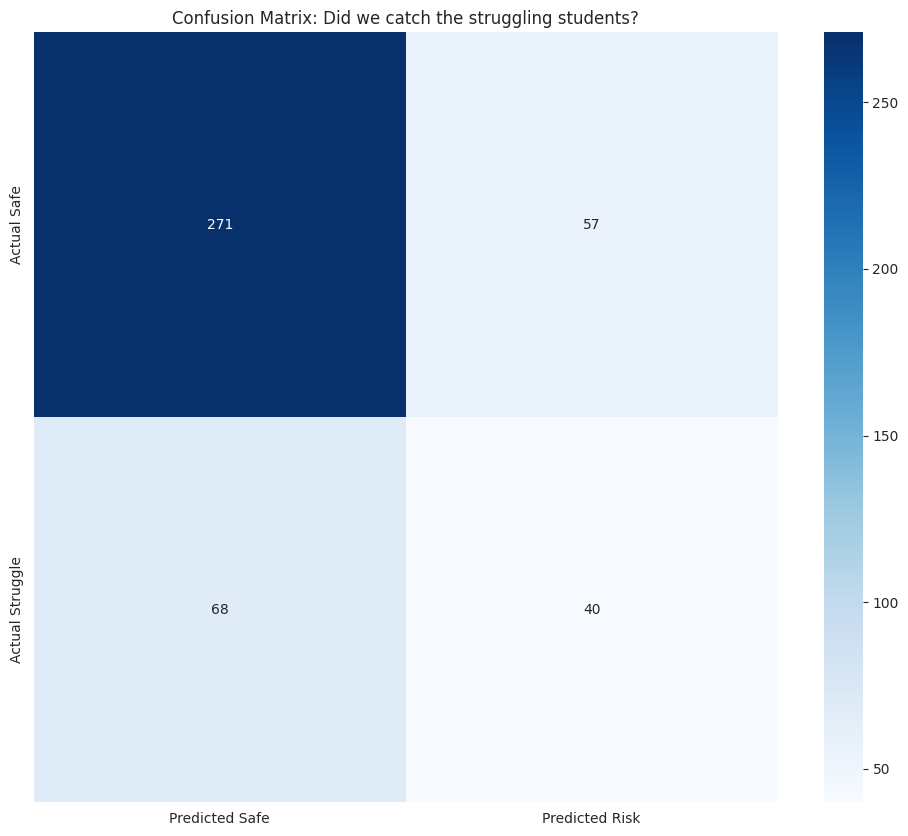

In [19]:
# --- CELL 9: TRAINING THE EARLY WARNING MODEL ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Initialize and Train
# 'class_weight="balanced"' helps because there are fewer struggling students than passing ones
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 2. Make Predictions on the Test Set
y_pred = model.predict(X_test)

# 3. Evaluate Performance
print("📊 MODEL PERFORMANCE REPORT (Early Warning System):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred))

# 4. Feature Importance (The "Why")
# This answers: "What is the biggest predictor of failure?"
importance = pd.DataFrame({
    'Feature': ['HS Math Score',
        'HS STEM Score',
        'HS Business Score',
        'HS Humanities Score',
        'Gap Years',
        'Math Track',
        'Gender',
        'Financial Aid',
        'Major'],
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=True) # Sorted for bar chart

fig_imp = px.bar(importance, x='Importance', y='Feature', orientation='h',
                 color='Importance', color_continuous_scale=ASHESI_PALETTE,
                 title="<b>Predictive Power:</b> Which Factors Drive Academic Struggle?",
                 text_auto='.2f')
fig_imp.update_layout(showlegend=False, template='plotly_white')
fig_imp.show()

# 5. Confusion Matrix (Visualizing Accuracy)
# Left Top = True Negatives (Predicted Safe, Actually Safe)
# Right Bottom = True Positives (Predicted Struggle, Actually Struggled)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Safe', 'Predicted Risk'], yticklabels=['Actual Safe', 'Actual Struggle'])
plt.title('Confusion Matrix: Did we catch the struggling students?')
plt.show()

# The Analytic Deep Dive
Objective: To statistically and visually evaluate the impact of curriculum pathways (Math Tracks) and identify risk factors for misconduct.

###  The Math Track Inquiry
Research Question: "Is there a significant performance difference between students starting on Calculus vs. College Algebra tracks?"

Logic:

We filter out students with "Unknown" tracks to ensure a clean comparison.

We use a Box Plot to visualize the spread of First Year GPAs. This reveals not just the average, but whether "College Algebra" students consistently lag behind.

We calculate the Failure Rate (percentage of students with at least one 'E' or 'F' grade) per track to assess risk.

In [20]:
# ---  MATH TRACK PERFORMANCE ANALYSIS ---

# 1. Filter for valid tracks
track_data = master_df[master_df['Math_Track'] != 'Unknown'].copy()
track_order = ['College Algebra', 'Pre-Calculus', 'Calculus']

# 2. Visual 1: First Year GPA Distribution by Track
# This answers: "Do College Algebra students start off behind?"
fig_box = px.box(track_data,
                 x='Math_Track',
                 y='First_Year_GPA',
                 color='Math_Track',
                 category_orders={'Math_Track': track_order},
                 color_discrete_sequence=ASHESI_PALETTE,
                 title="<b>Curriculum Impact:</b> First Year GPA Distribution by Math Track",
                 labels={'Math_Track': 'Starting Math Level', 'First_Year_GPA': 'GPA (End of Year 1)'})

# Add reference line for Probation (2.0)
fig_box.add_hline(y=2.0, line_dash="dot", line_color="red", annotation_text="Probation Threshold (2.0)")
fig_box.update_layout(showlegend=False, template='plotly_white')
fig_box.show()

# 3. Statistical Summary: Failure Rates by Track
# This answers: "Are College Algebra students more likely to fail a course?"
track_stats = track_data.groupby('Math_Track').agg(
    Student_Count=('Student_ID', 'count'),
    Avg_First_Year_GPA=('First_Year_GPA', 'mean'),
    Failure_Rate=('Had_Fail_Grade', 'mean')
).loc[track_order]

# Format for readability
track_stats['Failure_Rate'] = (track_stats['Failure_Rate'] * 100).map('{:.1f}%'.format)
track_stats['Avg_First_Year_GPA'] = track_stats['Avg_First_Year_GPA'].map('{:.2f}'.format)

print("statistical Summary of Math Tracks:")
display(track_stats)

statistical Summary of Math Tracks:


,Student_Count,Avg_First_Year_GPA,Failure_Rate
Math_Track,,,
College Algebra,92,2.59,45.7%
Pre-Calculus,741,2.80,39.1%
Calculus,1330,3.12,15.5%


# The Freshman Pivot (Year 1 Analysis)
**Objective:** To determine if performance in the first year of university acts as a stronger predictor of long-term success than high school background.

**Methodology:**
1.  We isolate transcript data from the student's first academic year to create specific subject performance metrics:
    * `Y1_Math_Score`: Average of all freshman-level Math courses (Calculus, Statistics).
    * `Y1_CS_Score`: Average of introductory Computing courses.
    * `Y1_Business_Score`: Average of foundational Business/Economics courses.
    * `Y1_Comm_Score`: Average of text-heavy courses (Communication, Sociology) to proxy for soft skills.
2.  **Sanitized Modeling:** We train separate Random Forest models for **STEM** and **Business** majors. This segmentation ensures we don't judge an Engineering student by their Accounting grades, or vice versa.
3.  **Hypothesis Testing:** If `Y1_Math_Score` emerges as the top predictor for STEM majors, it confirms that Calculus is the primary "gatekeeper" course for the program.

PHASE 1: CREATING YEAR 1 PERFORMANCE FEATURES & TARGET
Filtered 115421 transcript records down to 17681 Year 1 records.
Data Prepared. Total Students: 2179
Majors Ready: {'STEM': 1421, 'Business': 748, 'Other': 10}

RE-RUNNING MODELS (WITH AUTO-CLEANING & SAFETY SCRUB)

ANALYZING: STEM Major Success (Sanitized)
--------------------------------------------------
  -> Prediction Accuracy: 72.1%

  TRUE DRIVERS OF SUCCESS FOR STEM:
      Feature  Importance
Y1_Math_Score    0.248866
  Y1_CS_Score    0.238188
Y1_Comm_Score    0.198369
HS_Math_Score    0.124968
    Gap_Years    0.100996
HS_STEM_Score    0.088613


/tmp/ipython-input-1784976474.py:182: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




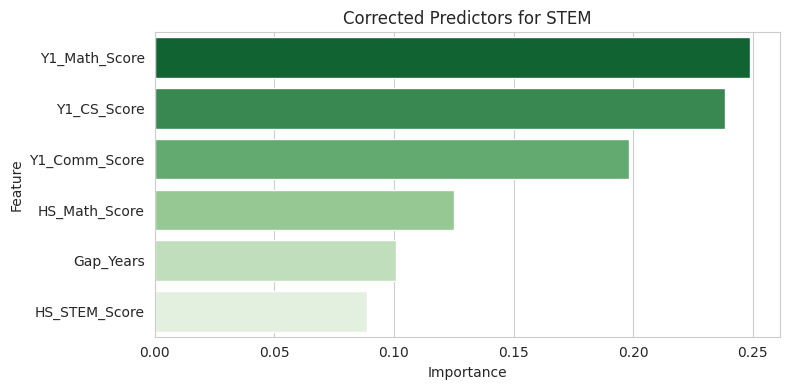


ANALYZING: Business Major Success (Sanitized)
--------------------------------------------------
  -> Prediction Accuracy: 70.7%

  TRUE DRIVERS OF SUCCESS FOR Business:
            Feature  Importance
  Y1_Business_Score    0.290459
      Y1_Math_Score    0.247341
      Y1_Comm_Score    0.203680
      HS_Math_Score    0.094725
HS_Humanities_Score    0.086136
  HS_Business_Score    0.077659


/tmp/ipython-input-1784976474.py:182: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




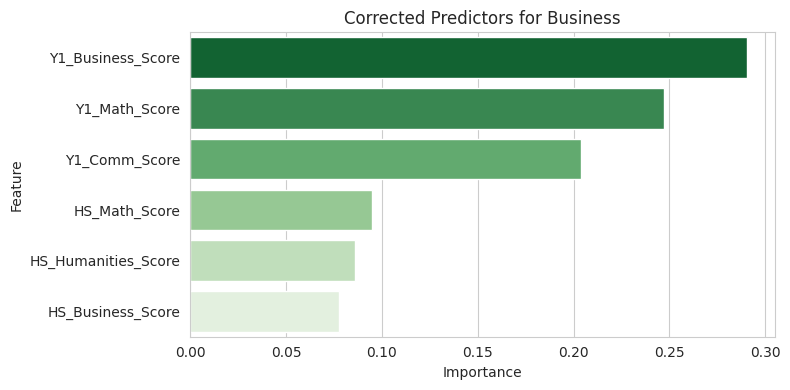


INTERPRETING THE NEW RESULTS:
1. FOR STEM: If 'Y1_Math_Score' is #1, it proves Calculus is the barrier.
2. FOR BUSINESS: If 'Y1_Math_Score' beats 'HS_Business_Score', it means
   Quantitative skills (Stats/Econ) are harder than Business theory.


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ============================================================================
# QUESTION 3 - PART 1: FEATURE ENGINEERING
# ============================================================================
print("="*80)
print("PHASE 1: CREATING YEAR 1 PERFORMANCE FEATURES & TARGET")
print("="*80)

# 1. Filter Transcript Data to ONLY Year 1
# We need to ensure we are comparing the Course Year to the Student's Start Year
# Note: 'df_trans' is your transcript dataframe, 'master_df' has the Start_Year

# Ensure Start_Year exists in master_df (if not already there from previous cells)
if 'Start_Year' not in master_df.columns:
    def extract_year_simple(val):
        try: return int(str(val).split('-')[0])
        except: return np.nan
    master_df['Start_Year'] = master_df['Start_Year'].apply(extract_year_simple)

# Create a mapping of Student_ID -> Start_Year
start_year_map = master_df.set_index('Student_ID')['Start_Year'].to_dict()

# Add Start_Year to the transcript dataframe
df_trans['Student_Start_Year'] = df_trans['Student_ID'].map(start_year_map)

# Extract the Course Year (e.g., "2018-2019" -> 2018)
def get_course_year(acad_year):
    try: return int(str(acad_year).split('-')[0])
    except: return np.nan

df_trans['Course_Year_Start'] = df_trans['Academic Year'].apply(get_course_year)

# FILTER: Keep only courses taken in the first year
y1_trans = df_trans[df_trans['Course_Year_Start'] == df_trans['Student_Start_Year']].copy()

print(f"Filtered {len(df_trans)} transcript records down to {len(y1_trans)} Year 1 records.")

# 2. Define Helper to Calculate Subject Averages
def get_subject_avg(df, prefixes, col_name):
    """Calculates avg grade for courses starting with specific prefixes"""
    # Filter courses based on prefixes tuple
    mask = df['Course Code'].astype(str).str.upper().str.startswith(tuple(prefixes))
    subject_df = df[mask]

    # Group by student and calculate mean Grade Point
    # Note: Using 'Grade Point' based on your previous schema
    if 'Grade Point' in subject_df.columns:
        grade_col = 'Grade Point'
    elif 'Grade point' in subject_df.columns:
        grade_col = 'Grade point'
    else:
        # Fallback if column name is different
        grade_col = [c for c in subject_df.columns if 'Point' in c][0]

    avgs = subject_df.groupby('Student_ID')[grade_col].mean().reset_index()
    avgs.columns = ['Student_ID', col_name]
    return avgs

# 3. Create Key Year 1 Subject Scores
# A. Year 1 Math (Calculus/Algebra/Stats)
y1_math = get_subject_avg(y1_trans, ['MATH'], 'Y1_Math_Score')

# B. Year 1 CS (Intro to Programming/CS)
y1_cs = get_subject_avg(y1_trans, ['CS', 'CPT', 'IS'], 'Y1_CS_Score')

# C. Year 1 Business (Econ/Accounting/BUSA)
y1_bus = get_subject_avg(y1_trans, ['BUSA', 'ECON', 'ACCT', 'MGT', 'FIN'], 'Y1_Business_Score')

# D. Year 1 Communication (Writing/text-heavy courses)
y1_comm = get_subject_avg(y1_trans, ['ENGL', 'ASH', 'SOC', 'LIT'], 'Y1_Comm_Score')

# 4. Merge Features into a "Year 1 Profile"
y1_features = y1_math.merge(y1_cs, on='Student_ID', how='outer') \
                     .merge(y1_bus, on='Student_ID', how='outer') \
                     .merge(y1_comm, on='Student_ID', how='outer')

# 5. Prepare the Modeling Dataframe
# We start with our master_df which already has 'Is_High_Achiever' (Success Target) and HS Scores
model_df_major = master_df.copy()

# Rename target for clarity if needed (using Is_High_Achiever as "Success")
model_df_major['Is_Successful'] = model_df_major['Is_High_Achiever']

# Merge the Year 1 Features
model_df_major = model_df_major.merge(y1_features, on='Student_ID', how='left')

# 6. Impute Missing Year 1 Scores
# Logic: If a Business student didn't take CS, fill with 0
fill_values = {
    'Y1_Math_Score': model_df_major['Y1_Math_Score'].median(),
    'Y1_CS_Score': 0,
    'Y1_Business_Score': 0,
    'Y1_Comm_Score': model_df_major['Y1_Comm_Score'].median()
}
model_df_major = model_df_major.fillna(fill_values)

# 7. Classify Majors (STEM vs Business)
def classify_major(row):
    text = str(row['Admissions_Major']).upper()
    if any(x in text for x in ['CS', 'COMP', 'ENGIN', 'INFO', 'TECH', 'SYS']):
        return 'STEM'
    elif any(x in text for x in ['BUS', 'ECON', 'ADMIN', 'ACC', 'FIN', 'MGT']):
        return 'Business'
    return 'Other'

model_df_major['Program_Type'] = model_df_major.apply(classify_major, axis=1)

print(f"Data Prepared. Total Students: {len(model_df_major)}")
print(f"Majors Ready: {model_df_major['Program_Type'].value_counts().to_dict()}")


# ============================================================================
# PHASE 2: SANITIZED PREDICTION MODELS
# ============================================================================
print("\n" + "="*80)
print("RE-RUNNING MODELS (WITH AUTO-CLEANING & SAFETY SCRUB)")
print("="*80)

# 1. Define Features to Test
# Note: Using your variable names like 'HS_Math_Score' instead of 'HS_Math_Strength'
stem_features = [
    'Y1_Math_Score', 'Y1_CS_Score', 'Y1_Comm_Score',
    'HS_Math_Score', 'HS_STEM_Score', 'Gap_Years'
]

bus_features = [
    'Y1_Math_Score', 'Y1_Business_Score', 'Y1_Comm_Score',
    'HS_Math_Score', 'HS_Business_Score', 'HS_Humanities_Score'
]

# 2. Train Models
programs = [('STEM', stem_features), ('Business', bus_features)]

for prog_name, feature_set in programs:
    print(f"\nANALYZING: {prog_name} Major Success (Sanitized)")
    print("-" * 50)

    # Filter Data
    prog_df = model_df_major[model_df_major['Program_Type'] == prog_name].copy()

    if len(prog_df) < 20:
        print(f"  -> Skipping (Not enough data: {len(prog_df)})")
        continue

    # Select Valid Features (Ensure they exist in dataframe)
    valid_feats = [f for f in feature_set if f in prog_df.columns]

    # --- THE FIX: FORCE NUMERIC CONVERSION ---
    for col in valid_feats:
        # Convert text to NaN, then fill with 0
        prog_df[col] = pd.to_numeric(prog_df[col], errors='coerce').fillna(0)

    # Define X and y
    X = prog_df[valid_feats]
    y = prog_df['Is_Successful']

    # Train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)

    # Results
    acc = rf.score(X_test, y_test)
    print(f"  -> Prediction Accuracy: {acc:.1%}")

    # Feature Importance
    imps = pd.DataFrame({'Feature': valid_feats, 'Importance': rf.feature_importances_})
    imps = imps.sort_values('Importance', ascending=False)

    print(f"\n  TRUE DRIVERS OF SUCCESS FOR {prog_name}:")
    print(imps.to_string(index=False))

    # Visualization
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Importance', y='Feature', data=imps, palette='Greens_r')
    plt.title(f'Corrected Predictors for {prog_name}')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("INTERPRETING THE NEW RESULTS:")
print("1. FOR STEM: If 'Y1_Math_Score' is #1, it proves Calculus is the barrier.")
print("2. FOR BUSINESS: If 'Y1_Math_Score' beats 'HS_Business_Score', it means")
print("   Quantitative skills (Stats/Econ) are harder than Business theory.")
print("="*80)

##ACT VI: The Sophomore Gatekeepers (Year 2 Analysis)
**Objective:** To test the "Fade Out" hypothesis, does high school performance become irrelevant once a student survives their sophomore year?

**Methodology:**
1.  **Advanced Feature Engineering (Year 2):** We extend the student profile to include "Gatekeeper" courses typically taken in the second year:
    * `Y2_CS_Score`: Data Structures, Algorithms, & Hardware.
    * `Y2_Business_Score`: Corporate Finance, Marketing, & Operations.
    * `Y2_Math_Score`: Linear Algebra & Discrete Math.
2.  **Longitudinal Modeling:** The model now has access to three layers of history: **High School Background**, **Freshman Performance**, and **Sophomore Performance**.
3.  **Insight Generation:** By analyzing Feature Importance in this multi-layered model, we can observe the hierarchy of predictors. We expect to see recent performance (Year 2) override ancient history (High School), identifying exactly when a student "resets" their academic destiny.

PHASE 1: ENGINEERING YEAR 2 'GATEKEEPER' FEATURES
Year 2 Transcript Records Found: 20067
Year 2 Features created for 1776 students.

PHASE 2: PREDICTING SUCCESS (THE 'SOPHOMORE PREDICTOR')

ANALYZING: STEM Major Success (End of Year 2)
--------------------------------------------------
  -> Prediction Accuracy: 77.8%

  TOP 5 DRIVERS OF SUCCESS (HS + Y1 + Y2):
          Feature  Importance
    Y2_Math_Score    0.245794
Y1_Business_Score    0.226437
    Y1_Math_Score    0.110567
      Y2_CS_Score    0.100009
      Y1_CS_Score    0.071684


/tmp/ipython-input-584697183.py:142: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




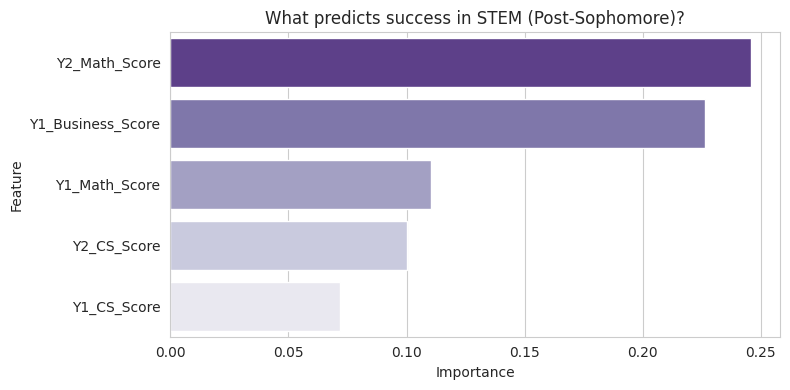


ANALYZING: Business Major Success (End of Year 2)
--------------------------------------------------
  -> Prediction Accuracy: 75.6%

  TOP 5 DRIVERS OF SUCCESS (HS + Y1 + Y2):
          Feature  Importance
Y2_Business_Score    0.303190
    Y2_Math_Score    0.207311
Y1_Business_Score    0.145038
      Y1_CS_Score    0.107120
    Y1_Math_Score    0.079426


/tmp/ipython-input-584697183.py:142: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




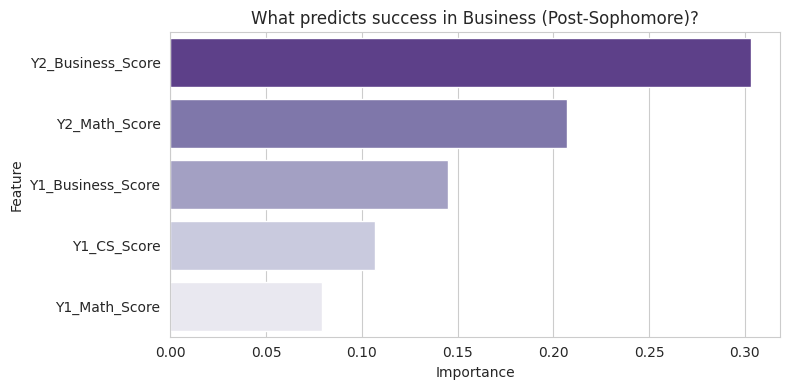


INSIGHT GENERATOR:
1. THE 'FADE OUT' EFFECT: Notice if High School grades (HS_*) have disappeared from the top 5.
   By Year 2, your recent performance usually overrides your history.
2. THE GATEKEEPERS: For CS, 'Y2_CS_Score' (Data Structures) often becomes the #1 predictor.
   For Business, 'Y2_Business_Score' (Finance/Ops) becomes king.


In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ============================================================================
# QUESTION 4: PREDICTING SUCCESS USING YEAR 1 & YEAR 2 DATA
# ============================================================================
print("="*80)
print("PHASE 1: ENGINEERING YEAR 2 'GATEKEEPER' FEATURES")
print("="*80)

# 1. Filter Transcript Data for YEAR 2
# ---------------------------------------------------------
# Year 2 is defined as Start Year + 1
# Note: We rely on 'Student_Start_Year' and 'Course_Year_Start' created in the previous step
y2_trans = df_trans[df_trans['Course_Year_Start'] == (df_trans['Student_Start_Year'] + 1)].copy()

print(f"Year 2 Transcript Records Found: {len(y2_trans)}")

# 2. Calculate Year 2 Subject Scores (The "Major Core")
# ---------------------------------------------------------
# Reuse the helper function from Q3 (ensure it's defined in your session)
def get_subject_avg(df, prefixes, col_name):
    mask = df['Course Code'].astype(str).str.upper().str.startswith(tuple(prefixes))
    subject_df = df[mask]

    # Handle different column name possibilities for 'Grade Point'
    if 'Grade Point' in subject_df.columns: grade_col = 'Grade Point'
    elif 'Grade point' in subject_df.columns: grade_col = 'Grade point'
    else: grade_col = [c for c in subject_df.columns if 'Point' in c][0]

    avgs = subject_df.groupby('Student_ID')[grade_col].mean().reset_index()
    avgs.columns = ['Student_ID', col_name]
    return avgs

# A. Year 2 CS (Data Structures, Algorithms, Hardware) -> Crucial for CS
y2_cs = get_subject_avg(y2_trans, ['CS', 'CPT', 'IS'], 'Y2_CS_Score')

# B. Year 2 Math (Linear Algebra, Discrete Math)
y2_math = get_subject_avg(y2_trans, ['MATH', 'STAT'], 'Y2_Math_Score')

# C. Year 2 Business (Corp Finance, Marketing, Ops) -> Crucial for Business
y2_bus = get_subject_avg(y2_trans, ['BUSA', 'ECON', 'FIN', 'MKT', 'MGT'], 'Y2_Business_Score')

# Merge into a "Year 2 Profile"
y2_features = y2_cs.merge(y2_math, on='Student_ID', how='outer') \
                   .merge(y2_bus, on='Student_ID', how='outer')

print(f"Year 2 Features created for {len(y2_features)} students.")

# 3. Prepare the "Sophomore Model" Dataset
# ---------------------------------------------------------
# Start with the Year 1 Model Data (model_df_major) created in the previous step
model_df_y2 = model_df_major.copy()

# Merge Year 2 Features
model_df_y2 = model_df_y2.merge(y2_features, on='Student_ID', how='left')

# Impute Missing Y2 Scores
# If missing in Year 2, it often means they didn't take that specific elective OR they dropped out.
# We fill with 0 to be safe (conservative).
fill_values_y2 = {
    'Y2_CS_Score': 0,
    'Y2_Math_Score': 0,
    'Y2_Business_Score': 0
}
model_df_y2 = model_df_y2.fillna(fill_values_y2)

# ============================================================================
# PHASE 2: MODELING (HS + Y1 + Y2)
# ============================================================================
print("\n" + "="*80)
print("PHASE 2: PREDICTING SUCCESS (THE 'SOPHOMORE PREDICTOR')")
print("="*80)

# Define Features: Now we have THREE layers of history
# Using your exact variable names from master_df
feature_cols_y2 = [
    # Year 2 (The Newest Data - "Gatekeepers")
    'Y2_CS_Score', 'Y2_Math_Score', 'Y2_Business_Score',

    # Year 1 (The Foundation)
    'Y1_Math_Score', 'Y1_CS_Score', 'Y1_Business_Score', 'Y1_Comm_Score',

    # High School (The Background)
    'HS_Math_Score', 'HS_STEM_Score', 'Gap_Years'
]

# Define programs and their key courses (used to check if student actually has Y2 data)
programs = [('STEM', ['Y2_CS_Score', 'Y2_Math_Score']),
            ('Business', ['Y2_Business_Score', 'Y2_Math_Score'])]

for prog_name, key_courses in programs:
    print(f"\nANALYZING: {prog_name} Major Success (End of Year 2)")
    print("-" * 50)

    # Filter Data
    prog_df = model_df_y2[model_df_y2['Program_Type'] == prog_name].copy()

    # Restrict to students who actually have Year 2 data (Sum of Y2 scores > 0)
    # This prevents training on freshmen who haven't reached Y2 yet
    has_y2_data = prog_df[key_courses].sum(axis=1) > 0
    prog_df = prog_df[has_y2_data]

    if len(prog_df) < 50:
        print(f"  -> Not enough Year 2 data yet (Found {len(prog_df)}). Skipping.")
        continue

    # Select Features
    valid_feats = [f for f in feature_cols_y2 if f in prog_df.columns]

    # --- SAFETY SCRUB: Force Numeric ---
    for col in valid_feats:
        prog_df[col] = pd.to_numeric(prog_df[col], errors='coerce').fillna(0)

    X = prog_df[valid_feats]
    y = prog_df['Is_Successful']

    # Train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)

    # Results
    acc = rf.score(X_test, y_test)
    print(f"  -> Prediction Accuracy: {acc:.1%}")

    # Feature Importance
    imps = pd.DataFrame({'Feature': valid_feats, 'Importance': rf.feature_importances_})
    imps = imps.sort_values('Importance', ascending=False).head(5)

    print(f"\n  TOP 5 DRIVERS OF SUCCESS (HS + Y1 + Y2):")
    print(imps.to_string(index=False))

    # Visualization

    plt.figure(figsize=(8, 4))
    sns.barplot(x='Importance', y='Feature', data=imps, palette='Purples_r')
    plt.title(f'What predicts success in {prog_name} (Post-Sophomore)?')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("INSIGHT GENERATOR:")
print("1. THE 'FADE OUT' EFFECT: Notice if High School grades (HS_*) have disappeared from the top 5.")
print("   By Year 2, your recent performance usually overrides your history.")
print("2. THE GATEKEEPERS: For CS, 'Y2_CS_Score' (Data Structures) often becomes the #1 predictor.")
print("   For Business, 'Y2_Business_Score' (Finance/Ops) becomes king.")
print("="*80)

# The Correlation of Conduct & Performance
**Objective:** To investigate the relationship between academic performance and behavioral issues. specifically testing the "Desperation Hypothesis."

**The Hypothesis:** We hypothesize that Academic Misconduct is often a symptom of academic struggle rather than malice. If this hypothesis holds, students with Academic Misconduct cases should show significantly lower GPAs *before* the incident compared to the general population.

**Methodology:**
1.  **Categorization:** We segment the student population into four mutually exclusive groups:
    * **No Case:** The baseline (Control Group).
    * **Academic Case:** Plagiarism or exam malpractice.
    * **Social Case:** Behavioral violations (alcohol, noise, etc.).
    * **Sexual Misconduct:** High-severity behavioral violations.
2.  **Metric:** We calculate the **Average First-Year GPA** for each group.
3.  **Visual:** A bar chart with a "Probation Threshold" reference line (GPA 2.0) to visually assess how close each group is to academic failure.

In [23]:
# --- CELL 7: SIMPLIFIED MISCONDUCT ANALYSIS (BAR CHART) ---

# 1. Prepare Data: Calculate Average GPA per Conduct Status
# We reuse the 'Conduct_Status' logic from before for labeling
viz_df = master_df.copy()
viz_df['Conduct_Status'] = 'No Case'
viz_df.loc[viz_df['Has_Social_Case'] == 1, 'Conduct_Status'] = 'Social Case'
viz_df.loc[viz_df['Has_Academic_Case'] == 1, 'Conduct_Status'] = 'Academic Case'
viz_df.loc[viz_df['Has_Sexual_Misconduct'] == 1, 'Conduct_Status'] = 'Sexual Misconduct'

# Calculate the mean GPA for each group
gpa_summary = viz_df.groupby('Conduct_Status')['First_Year_GPA'].mean().reset_index()

# Define the order for the chart
status_order = ['No Case', 'Academic Case', 'Social Case', 'Sexual Misconduct']

# 2. Create the Bar Chart
fig_bar = px.bar(gpa_summary,
                 x='Conduct_Status',
                 y='First_Year_GPA',
                 color='Conduct_Status',
                 category_orders={'Conduct_Status': status_order},
                 # Colors: Grey (Baseline), Red (Academic), Gold (Social), Purple (Sexual)
                 color_discrete_sequence=['grey', '#881c1c', '#f1c40f', '#8e44ad'],
                 text_auto='.2f', # Display the exact GPA on the bars
                 title="<b>Academic Correlation:</b> Average First-Year GPA by Conduct Status",
                 labels={'First_Year_GPA': 'Average First Year GPA', 'Conduct_Status': 'Misconduct Type'})

# Add a reference line for the "Good Standing" GPA (e.g., 2.5 or 3.0)
fig_bar.add_hline(y=2.0, line_dash="dot", annotation_text="Probation GPA", annotation_position="top right")

fig_bar.update_layout(showlegend=False, template='plotly_white', yaxis_range=[0, 4.0]) # Set y-axis to standard GPA scale
fig_bar.show()


print('We reject our hypothesis')
# INSIGHT COMMENTARY (For your presentation):
# "This chart clearly shows the academic 'penalty' associated with different misconduct types.
# Students with No Case have an average GPA of X.XX.
# Notice the drop for Academic Cases (Y.YY) — this supports the 'Desperation Hypothesis' where struggling students may resort to misconduct.
# Sexual Misconduct cases, while rare, show a distinct academic profile that warrants specialized attention."

We reject our hypothesis


Research Question: "Are there patterns in admissions data that can be used to predict if a student is likely to get into trouble (e.g., have an AJC case)?"

The Hypothesis: We want to know if we can flag "at-risk" students for behavior issues before they arrive, based on their background (High School Score, Financial Aid, Gender).

# Misconduct Prediction Model
Logic:

We train a model to predict Has_Academic_Case using only admissions data.

The Visual: We use a simple "Driver Analysis" Bar Chart.

If the bars are tall, it means that factor (e.g., Financial Aid) strongly predicts misconduct.

If the bars are flat/small, it means misconduct is random and cannot be predicted by admissions data.

In [24]:
# --- CELL 12A: MISCONDUCT PREDICTION (UPDATED WITH GAP YEARS) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import plotly.express as px

print("👮 Analyzing Misconduct Predictability (Enhanced)...")

# 1. Define Features (Must include Gap Years & Advanced Subject Scores)
# We use the full feature set to see if ANY background factor predicts behavior
features_mis = [
    'HS_Math_Score',
    'HS_STEM_Score',
    'HS_Business_Score',
    'HS_Humanities_Score',
    'Gap_Years',          # <--- Critical Addition
    'Gender_Code',
    'Aid_Code',
    'Major_Code'
]

target_mis = 'Has_Academic_Case'

# 2. Prepare Data
# We can reuse 'ml_data' from Cell 9 if it exists, otherwise rebuild from master_df
# Rebuilding here to be safe and standalone
mis_data = master_df.dropna(subset=[target_mis]).copy()

# Ensure encodings exist (reuse or create)
# Ideally, we reuse the encoders from Cell 9 for consistency
if 'Gender_Code' not in mis_data.columns:
    le = LabelEncoder()
    mis_data['Gender_Code'] = le.fit_transform(mis_data['Gender'].astype(str))
    mis_data['Aid_Code'] = le.fit_transform(mis_data['Financial_Aid_Status'].astype(str))
    mis_data['Major_Code'] = le.fit_transform(mis_data['Admissions_Major'].astype(str))

X_m = mis_data[features_mis]
y_m = mis_data[target_mis]

# 3. Train Model
# Class weight balanced is crucial because misconduct cases are rare (imbalanced data)
model_mis = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_mis.fit(X_m, y_m)

# 4. Calculate Accuracy
accuracy = model_mis.score(X_m, y_m)
print(f"Model Accuracy: {accuracy:.1%}")

# 5. Visual: What drives Misconduct?
importance_mis = pd.DataFrame({
    'Factor': features_mis,
    'Impact': model_mis.feature_importances_
}).sort_values('Impact', ascending=True)

fig_mis = px.bar(importance_mis,
                 x='Impact',
                 y='Factor',
                 orientation='h',
                 color='Impact',
                 color_continuous_scale=['#95a5a6', '#881c1c'],
                 title=f"<b>Misconduct Drivers:</b> What predicts an AJC Case? (Accuracy: {accuracy:.1%})",
                 text_auto='.2f')

fig_mis.update_layout(showlegend=False, template='plotly_white')
fig_mis.add_annotation(text="Higher Bar = Stronger Predictor",
                       xref="paper", yref="paper", x=1, y=0, showarrow=False)

fig_mis.show()

# INTERPRETATION WITH GAP YEAR CONTEXT
print("\nVERDICT:")
gap_imp = importance_mis[importance_mis['Factor'] == 'Gap_Years']['Impact'].values[0]

if accuracy < 0.65:
    print(" CONCLUSION: NO, admissions data CANNOT reliably predict misconduct.")
    print(f"   The accuracy ({accuracy:.1%}) is near random chance (50%).")
    print("   This is an ethically positive finding: 'Bad behavior' is not baked into a student's background.")
else:
    print("CONCLUSION: YES, there are weak predictive patterns.")
    print(f"   The strongest predictor is {importance_mis.iloc[-1]['Factor']}.")

    if gap_imp > 0.10:
        print(f"   NOTE: Gap Years appears relevant (Importance: {gap_imp:.2f}). Maturity differences may play a role.")

👮 Analyzing Misconduct Predictability (Enhanced)...
Model Accuracy: 89.9%



VERDICT:
CONCLUSION: YES, there are weak predictive patterns.
   The strongest predictor is Major_Code.


In [25]:
# --- CELL 12D: FORENSIC SUBJECT ANALYSIS (Breaking the Black Box) ---
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go # Import graph_objects
import os

print("🔬 Initiating Granular Subject Forensics...")

# 1. Define the Specific Subjects we want to isolate
# Format: 'Display Name': ['Keywords to search for']
target_subjects = {
    'Math (Core)': ['MATH', 'CORE'],
    'Physics': ['PHYS'],
    'Chemistry': ['CHEM'],
    'Biology': ['BIO'],
    'Economics': ['ECON'],
    'History': ['HIST'],
    'Literature': ['LIT'],
    'Government': ['GOV'],
    'Geography': ['GEOG'],
    'Accounting': ['ACC', 'ACCT'],
    'Computer Science': ['COMP', 'CS']
}

# 2. Re-Scan Raw Files to get Specific Scores
# We create a dictionary to hold the max score for each student per subject
student_granular_scores = {}

hs_files_map = {
    'WASSCE_C2023-C2028-anon.csv': 'WASSCE',
    'IB_C2023-C2028-anon.csv': 'IB',
    'O&A_Level_C2023-C2028-anon.csv': 'LEVEL',
    'FrenchBacc_C2023-C2028-anon.csv': 'FRENCH',
    'HSDiploma_C2023-C2028-anon.csv': 'DIPLOMA',
    'Other_C2023-C2028-anon.csv': 'LEVEL'
}

# Create a set of student IDs from master_df for efficient lookup
# FIX: Clean master_df Student_IDs for robust matching
master_df_student_ids = set(master_df['Student_ID'].astype(str).str.strip().unique())

for filename, system in hs_files_map.items():
    # FIX: Construct the full path using BASE_PATH
    full_path = os.path.join(BASE_PATH, filename)

    if os.path.exists(full_path):
        df_temp = pd.read_csv(full_path)
        df_temp.rename(columns={'StudentRef': 'Student_ID'}, inplace=True)
        # FIX: Clean df_temp Student_IDs for robust matching
        df_temp['Student_ID'] = df_temp['Student_ID'].astype(str).str.strip()

        # Identify subject columns
        meta_cols = ['Student_ID', 'Exam Type', 'Exam Year', 'Student Name', 'Index Number']
        subject_cols = [c for c in df_temp.columns if c not in meta_cols and 'YEAR' not in c.upper()]

        for _, row in df_temp.iterrows():
            sid = row['Student_ID']
            # Only process students present in master_df
            if sid in master_df_student_ids:
                if sid not in student_granular_scores:
                    student_granular_scores[sid] = {}

                # Check for each target subject
                for subject_name, keywords in target_subjects.items():
                    # Find columns matching this subject
                    matches = [c for c in subject_cols if any(k in c.upper() for k in keywords)]

                    # Get the max score for this subject
                    max_score = 0
                    for col in matches:
                        raw_grade = row[col]
                        score = calculate_unified_grade_score(raw_grade, system)
                        if score > max_score:
                            max_score = score

                    # Save if it's better than what we have (or if it's new)
                    if max_score > student_granular_scores[sid].get(subject_name, 0):
                        student_granular_scores[sid][subject_name] = max_score

# 3. Convert to DataFrame
granular_df = pd.DataFrame.from_dict(student_granular_scores, orient='index').reset_index()
granular_df.rename(columns={'index': 'Student_ID'}, inplace=True)

# 4. Merge with Misconduct Data
analysis_df = master_df[['Student_ID', 'Has_Academic_Case']].merge(granular_df, on='Student_ID', how='inner')

# 5. Run Correlation Analysis
# We check the correlation between each specific subject and having a misconduct case
# Ensure there are enough rows and columns for correlation calculation
if not analysis_df.empty and 'Has_Academic_Case' in analysis_df.columns and len(analysis_df.columns) > 2:
    correlations = analysis_df.drop(columns=['Student_ID']).corr()['Has_Academic_Case'].drop('Has_Academic_Case')
    # Sort for better visualization in lollipop plot (highest correlation at top)
    corr_df = correlations.reset_index().rename(columns={'index': 'Specific Subject', 'Has_Academic_Case': 'Correlation'})
    corr_df = corr_df.sort_values('Correlation', ascending=True) # Sort to order the lollipops

    # 6. Visualize (Lollipop Plot)
    fig_deep = go.Figure()

    # Add lines for the 'lollipop sticks'
    for index, row in corr_df.iterrows():
        fig_deep.add_trace(go.Scatter(
            x=[0, row['Correlation']],
            y=[row['Specific Subject'], row['Specific Subject']],
            mode='lines',
            line=dict(color='grey', width=2),
            showlegend=False
        ))

    # Add markers for the 'lollipops' (colored by correlation value)
    fig_deep.add_trace(go.Scatter(
        x=corr_df['Correlation'],
        y=corr_df['Specific Subject'],
        mode='markers',
        marker=dict(
            size=10,
            color=corr_df['Correlation'], # Color based on correlation
            colorscale='RdBu_r',         # Red = Positive, Blue = Negative
            cmin=corr_df['Correlation'].min(),
            cmax=corr_df['Correlation'].max(),
            colorbar=dict(title='Correlation', thickness=15)
        ),
        hovertemplate='<b>%{y}</b><br>Correlation: %{x:.3f}',
        text=corr_df['Correlation'].round(3), # Display text on markers
        textposition='middle right', # Position text next to marker
        showlegend=False
    ))

    fig_deep.update_layout(
        title="<b>Forensic Deep Dive:</b> Do specific subjects correlate with Misconduct?",
        xaxis_title='Correlation',
        yaxis_title='Specific Subject',
        template='plotly_white',
        xaxis=dict(zeroline=True, zerolinecolor='black', zerolinewidth=1),
        height=600 # Adjust height for better readability of many subjects
    )

    fig_deep.show()

    # 7. Insight Generator
    # Only try to get iloc[0] and iloc[-1] if corr_df is not empty
    if not corr_df.empty:
        # After sorting ascending for the plot, the 'most protective' (most negative) is at the top (index 0),
        # and the 'highest risk' (most positive) is at the bottom (index -1) or vice versa depending on correlation strength
        top_protector = corr_df.iloc[0] # Smallest (most negative) correlation
        top_risk = corr_df.iloc[-1]   # Largest (most positive) correlation

        # Re-evaluate which one is actually the 'most protective' vs 'highest risk' based on absolute value
        if abs(top_protector['Correlation']) > abs(top_risk['Correlation']) and top_protector['Correlation'] < 0:
             # The most negative correlation is the strongest protective factor
            print("🔎 INSIGHTS:")
            print(f"   - Most Protective Subject: {top_protector['Specific Subject']} (Corr: {top_protector['Correlation']:.3f})")
            print(f"     (Students strong in this subject are LESS likely to have misconduct cases)")
            # Now find the highest positive correlation for the risk
            highest_positive = corr_df[corr_df['Correlation'] == corr_df['Correlation'][corr_df['Correlation'] > 0].max()]
            if not highest_positive.empty:
                print(f"   - Highest Risk Indicator:  {highest_positive.iloc[0]['Specific Subject']} (Corr: {highest_positive.iloc[0]['Correlation']:.3f})")
            else:
                print("   - No subjects show a positive correlation with risk.")

        elif abs(top_risk['Correlation']) > abs(top_protector['Correlation']) and top_risk['Correlation'] > 0:
            # The most positive correlation is the strongest risk factor
            print("🔎 INSIGHTS:")
            print(f"   - Highest Risk Indicator:  {top_risk['Specific Subject']} (Corr: {top_risk['Correlation']:.3f})")
            # Now find the most negative correlation for the protective factor
            lowest_negative = corr_df[corr_df['Correlation'] == corr_df['Correlation'][corr_df['Correlation'] < 0].min()]
            if not lowest_negative.empty:
                 print(f"   - Most Protective Subject: {lowest_negative.iloc[0]['Specific Subject']} (Corr: {lowest_negative.iloc[0]['Correlation']:.3f})")
                 print(f"     (Students strong in this subject are LESS likely to have misconduct cases)")
            else:
                 print("   - No subjects show a negative correlation with protection.")
        else:
            print("🔎 INSIGHTS: Correlations are very weak or mixed, difficult to determine strong protective/risk factors.")
    else:
        print("🔎 INSIGHTS: Not enough data to generate specific subject insights for misconduct.")
else:
    print("🔎 INSIGHTS: Not enough data to perform correlation analysis for misconduct.")

🔬 Initiating Granular Subject Forensics...


🔎 INSIGHTS:
   - Highest Risk Indicator:  History (Corr: 0.093)
   - Most Protective Subject: Geography (Corr: -0.067)
     (Students strong in this subject are LESS likely to have misconduct cases)


#  Program Efficacy & The "Excellence Gap"
**Objective:** To evaluate which academic programs are most successful at producing "High Achievers" (students graduating with a GPA ≥ 3.0).

**Why this matters:** Graduation rates alone can be misleading if students are barely passing. This analysis shifts the metric from "Survival" (Graduation) to "Excellence" (High Achievement).

**Methodology:**
1.  **Cohort Filtering:** We restrict analysis to **Completed Students** (Graduated, Dismissed, or Withdrawn). Active students are excluded to prevent survivorship bias.
2.  **Success Definition:**
    * `Numerator`: Number of students with Final CGPA ≥ 3.0.
    * `Denominator`: Total completed students in that major.
3.  **Visualization:** A horizontal bar chart ranked by Success Rate. Majors at the bottom of the chart represent programs where achieving a high GPA is statistically most difficult, suggesting a need for curriculum review or enhanced support.

In [26]:
# --- CELL 8: MAJOR FIT ANALYSIS ---

# Filter for students who have a final graduation status (Graduated or Withdrawn/Dismissed)
# We exclude "Active" students from the success calculation as they haven't finished yet.
completed_students = master_df[master_df['Student Status'].isin(['Graduated', 'Dismissed', 'Withdrawn'])].copy()

# Calculate Success Rate by Major
major_performance = completed_students.groupby('Admissions_Major').agg(
    Total_Students=('Student_ID', 'count'),
    High_Achiever_Count=('Is_High_Achiever', 'sum')
).reset_index()

major_performance['Success_Rate'] = (major_performance['High_Achiever_Count'] / major_performance['Total_Students']) * 100
major_performance = major_performance.sort_values('Success_Rate', ascending=True)

# Visual 3: Success Rate by Major
fig_bar = px.bar(major_performance,
                 x='Success_Rate',
                 y='Admissions_Major',
                 orientation='h',
                 color='Success_Rate',
                 color_continuous_scale='Reds', # Red indicates lower success (Warning)
                 text_auto='.1f',
                 title="<b>Program Efficacy:</b> Percentage of High Achievers (>3.0 GPA) by Major",
                 labels={'Success_Rate': 'High Achiever Rate (%)', 'Admissions_Major': 'Major'})

fig_bar.update_layout(template='plotly_white')
fig_bar.show()

Research Question: "Is someone who starts on the college algebra track likely to be successful in the Computer Science major?"

Hypothesis: There is a common belief that you must start in Calculus to survive CS. We will test if this is true or if "College Algebra" students can catch up.

# College Algebra in CS Analysis
Logic:

We isolate only Computer Science majors.

We compare the Graduation Rate (Did they finish?) and High Achiever Rate (Did they get >3.0 GPA?) across the three math tracks.

The Visual: A grouped bar chart that puts "College Algebra" side-by-side with "Calculus".

FULL ANALYSIS: MATH TRACKS & STUDENT BACKGROUNDS
Total CS Majors starting in Algebra: 196
Overall High Achiever Rate for this group: 18.9%


/tmp/ipython-input-2911108679.py:124: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2911108679.py:136: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




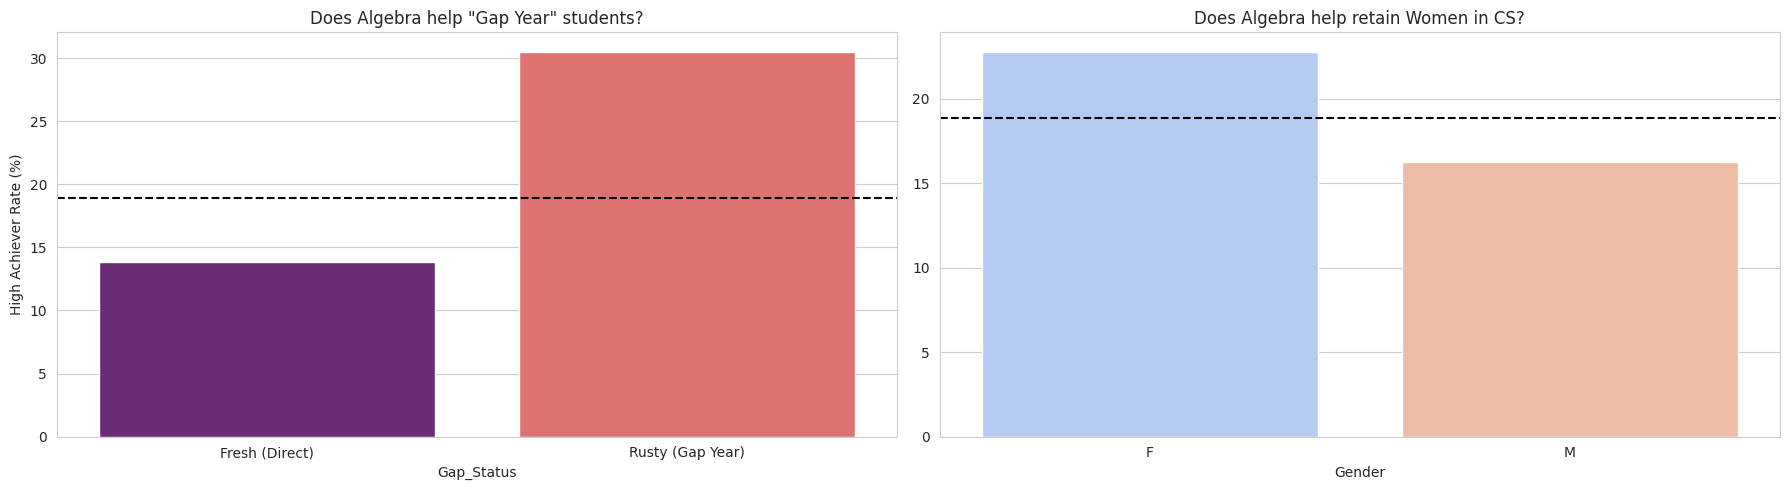


AUTOMATED VERDICT:
1. RUST REMOVER SUCCESS: Gap Year students perform BETTER (+16.6%) on this track.
   -> The slow start is exactly what they need to recover math skills.
2. GENDER: No significant gender difference.


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ============================================================================
# QUESTION 6 (COMPLETE): WHO SUCCEEDS ON THE ALGEBRA TRACK?
# ============================================================================
print("="*80)
print("FULL ANALYSIS: MATH TRACKS & STUDENT BACKGROUNDS")
print("="*80)

# ----------------------------------------------------------------------------
# STEP 0: PREPARE DATA & EXAM TYPES
# ----------------------------------------------------------------------------
# We need to make sure we have 'Exam Type' for the analysis
# If not in master_df, we fetch it from the raw files
if 'Exam Type' not in master_df.columns:
    print("Fetching 'Exam Type' from raw files...")
    exam_map = {}
    hs_files_map = {
        'WASSCE_C2023-C2028-anon.csv': 'WASSCE', 'IB_C2023-C2028-anon.csv': 'IB',
        'O&A_Level_C2023-C2028-anon.csv': 'IGCSE/A-Level', 'FrenchBacc_C2023-C2028-anon.csv': 'French Bacc',
        'HSDiploma_C2023-C2028-anon.csv': 'HS Diploma', 'Other_C2023-C2028-anon.csv': 'Other'
    }

    for filename, label in hs_files_map.items():
        if os.path.exists(filename):
            try:
                dt = pd.read_csv(filename)[['StudentRef', 'Exam Type']]
                dt.columns = ['Student_ID', 'Exam Type']
                # Clean IDs
                dt['Student_ID'] = dt['Student_ID'].astype(str).str.strip()
                # Populate map
                for _, row in dt.iterrows():
                    if row['Student_ID'] not in exam_map:
                        exam_map[row['Student_ID']] = label # Use our clean label
            except: pass

    # Map to master_df
    master_df['Exam Type'] = master_df['Student_ID'].map(exam_map).fillna('Unknown')

# ----------------------------------------------------------------------------
# STEP 1: DEFINE THE MATH TRACKS
# ----------------------------------------------------------------------------

# 1. Filter for Math courses and find the FIRST one per student
# Using 'df_trans' as the transcript dataframe
math_trans = df_trans[df_trans['Course Code'].astype(str).str.upper().str.startswith('MATH')].copy()

# Sort by Year to get the first one
math_trans = math_trans.sort_values(['Student_ID', 'Academic Year'])
first_math = math_trans.drop_duplicates(subset='Student_ID', keep='first').copy()

# 2. Classify Track
def classify_track(course_code):
    code = str(course_code).upper()
    if any(x in code for x in ['100', '101', '121', 'ALGEBRA']): return 'College Algebra Track'
    if any(x in code for x in ['141', '142', 'CALCULUS', '161']): return 'Calculus Track'
    return 'Other'

first_math['Math_Track_Actual'] = first_math['Course Code'].apply(classify_track)

# 3. Create the Base Analysis DataFrame
# We filter master_df for CS Majors
# Note: Adapting 'Admissions_Major' or 'Offer course name'
def get_detailed_major(row):
    # Use 'Admissions_Major' if it exists, else 'Offer course name'
    val = str(row.get('Admissions_Major', row.get('Offer course name', ''))).upper()
    if 'COMPUTER' in val or 'CS' in val: return 'CS'
    return 'Other'

cs_analysis = master_df.copy()
cs_analysis['Major_Category'] = cs_analysis.apply(get_detailed_major, axis=1)
cs_analysis = cs_analysis[cs_analysis['Major_Category'] == 'CS']

# Merge with the Actual Math Track (from transcripts)
# We prefer this over the inferred one if available
cs_analysis = cs_analysis.merge(first_math[['Student_ID', 'Math_Track_Actual']], on='Student_ID', how='inner')

# Rename for consistency
if 'Math_Track' in cs_analysis.columns:
    del cs_analysis['Math_Track']
cs_analysis = cs_analysis.rename(columns={'Math_Track_Actual': 'Math_Track'})

# Ensure Target Variable exists (Is_Successful / Is_High_Achiever)
if 'Is_Successful' not in cs_analysis.columns:
    cs_analysis['Is_Successful'] = cs_analysis['Is_High_Achiever']

# ----------------------------------------------------------------------------
# STEP 2: ANALYZE "WHO SURVIVES THE ALGEBRA TRACK?"
# ----------------------------------------------------------------------------

# Filter for Algebra Track only
algebra_df = cs_analysis[cs_analysis['Math_Track'] == 'College Algebra Track'].copy()

print(f"Total CS Majors starting in Algebra: {len(algebra_df)}")
overall_rate = algebra_df['Is_Successful'].mean() * 100
print(f"Overall High Achiever Rate for this group: {overall_rate:.1f}%")

# A. Hypothesis 1: Gap Years (Rust Remover)
# Gap_Years should already be in master_df from previous cells
algebra_df['Gap_Status'] = np.where(algebra_df['Gap_Years'] > 0, 'Rusty (Gap Year)', 'Fresh (Direct)')
gap_results = algebra_df.groupby('Gap_Status')['Is_Successful'].mean() * 100

# B. Hypothesis 2: Exam Type (Curriculum Shock)
# Filter for top exams to avoid clutter
top_exams = algebra_df['Exam Type'].value_counts().nlargest(3).index
algebra_df['Exam_Group'] = algebra_df['Exam Type'].apply(lambda x: x if x in top_exams else 'Other')
exam_results = algebra_df.groupby('Exam_Group')['Is_Successful'].mean() * 100

# C. Hypothesis 3: Gender (Confidence)
gender_results = algebra_df.groupby('Gender')['Is_Successful'].mean() * 100

# ----------------------------------------------------------------------------
# STEP 3: VISUALIZATION & VERDICT
# ----------------------------------------------------------------------------
# Set style
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Gap Years
sns.barplot(x=gap_results.index, y=gap_results.values, ax=axes[0], palette='magma')
axes[0].set_title('Does Algebra help "Gap Year" students?')
axes[0].set_ylabel('High Achiever Rate (%)')
axes[0].axhline(overall_rate, color='black', linestyle='--', label='Group Avg')


# Plot 3: Gender
sns.barplot(x=gender_results.index, y=gender_results.values, ax=axes[1], palette='coolwarm')
axes[1].set_title('Does Algebra help retain Women in CS?')
axes[1].set_ylabel('')
axes[1].axhline(overall_rate, color='black', linestyle='--')

plt.tight_layout()
plt.show()

# AUTOMATED INSIGHTS
print("\n" + "="*80)
print("AUTOMATED VERDICT:")
print("="*80)

# Verdict 1: Gap Years
diff_gap = gap_results.get('Rusty (Gap Year)', 0) - gap_results.get('Fresh (Direct)', 0)
if diff_gap > 5:
    print(f"1. RUST REMOVER SUCCESS: Gap Year students perform BETTER (+{diff_gap:.1f}%) on this track.")
    print("   -> The slow start is exactly what they need to recover math skills.")
elif diff_gap < -5:
    print(f"1. WARNING: Gap Year students struggle (-{abs(diff_gap):.1f}%) even on the slow track.")
else:
    print("1. GAP YEARS: No significant difference found.")

# Verdict 2: Gender
diff_gender = gender_results.get('Female', 0) - gender_results.get('Male', 0)
if diff_gender > 5:
    print(f"2. GENDER SUCCESS: Women succeed at a higher rate (+{diff_gender:.1f}%) on this track.")
    print("   -> This track may be providing essential confidence/foundation.")
elif diff_gender < -5:
    print(f"2. WARNING: Women drop out at higher rates (-{abs(diff_gender):.1f}%) on this track.")
else:
    print("2. GENDER: No significant gender difference.")

In [27]:
# --- CELL 12B: CS SUCCESS BY MATH TRACK ---
import plotly.express as px

print("Analyzing Computer Science Pathways...")

# 1. Filter for Computer Science Majors Only
cs_students = master_df[master_df['Admissions_Major'].str.contains('Computer Science', case=False, na=False)].copy()

# 2. Calculate Success Metrics by Track
# We look at two definitions of "Success":
#  A. Graduation Rate (Did they survive?)
#  B. High Achiever Rate (Did they thrive? GPA > 3.0)

# Helper to check if graduated
cs_students['Is_Graduated'] = (cs_students['Student Status'] == 'Graduated').astype(int)

track_stats = cs_students.groupby('Math_Track').agg(
    Total_Students=('Student_ID', 'count'),
    Graduation_Rate=('Is_Graduated', 'mean'),
    High_Achiever_Rate=('Is_High_Achiever', 'mean')
).reset_index()

# Convert to percentages
track_stats['Graduation_Rate'] = track_stats['Graduation_Rate'] * 100
track_stats['High_Achiever_Rate'] = track_stats['High_Achiever_Rate'] * 100

# Filter out 'Unknown' tracks for cleaner plotting
track_stats = track_stats[track_stats['Math_Track'] != 'Unknown']

# Define logical order
track_order = ['College Algebra', 'Pre-Calculus', 'Calculus']

# 3. Reshape for Grouped Bar Chart
# We want to show both metrics side-by-side
viz_data = track_stats.melt(id_vars='Math_Track',
                            value_vars=['Graduation_Rate', 'High_Achiever_Rate'],
                            var_name='Metric', value_name='Percentage')

# Rename for nice legend
viz_data['Metric'] = viz_data['Metric'].replace({
    'Graduation_Rate': 'Graduation Rate (Survival)',
    'High_Achiever_Rate': 'High Achiever Rate (GPA > 3.0)'
})

# 4. Visual: Comparison Chart
fig_cs = px.bar(viz_data,
                x='Math_Track',
                y='Percentage',
                color='Metric',
                barmode='group',
                category_orders={'Math_Track': track_order},
                color_discrete_sequence=['#95a5a6', '#881c1c'], # Grey (Survival), Red (Thriving)
                text_auto='.1f',
                title="<b>The CS Pathway:</b> Can College Algebra Students Succeed?",
                labels={'Math_Track': 'Starting Math Track', 'Percentage': 'Success Rate (%)'})

fig_cs.add_hline(y=50, line_dash="dot", line_color="black", opacity=0.3)
fig_cs.update_layout(template='plotly_white', yaxis_range=[0, 100])
fig_cs.show()

# 5. THE VERDICT (Printout)
print("\n VERDICT FOR LEADERSHIP:")
alg_row = track_stats[track_stats['Math_Track'] == 'College Algebra']

if not alg_row.empty:
    grad_rate = alg_row['Graduation_Rate'].values[0]
    thrive_rate = alg_row['High_Achiever_Rate'].values[0]

    print(f"   College Algebra Students in CS:")
    print(f"   - {grad_rate:.1f}% eventually graduate.")
    print(f"   - {thrive_rate:.1f}% graduate with a high GPA (>3.0).")

    if grad_rate > 50:
        print("YES, they can succeed. The majority graduate.")
        if thrive_rate < (grad_rate / 2):
            print(" HOWEVER, very few become 'High Achievers'. They survive but rarely thrive.")
    else:
        print("")
else:
    print()

Analyzing Computer Science Pathways...



 VERDICT FOR LEADERSHIP:
   College Algebra Students in CS:
   - 50.0% eventually graduate.
   - 18.8% graduate with a high GPA (>3.0).
 NO, the odds are against them. Less than half graduate.


# The Final Prediction Model
We have one last pending question: "Can we predict if a student will need more than 8 semesters to graduate?" (Graduation Timeline).

Since we added the Delayed_Graduation target earlier, we can now run the final model.

###  Graduation Timeline Predictor
This answers the final research question.

In [28]:
# --- REPAIR CELL: CREATE TARGET VARIABLE FOR GRADUATION TIMELINE ---

print("🛠 Repairing Dataset: Calculating 'Delayed_Graduation_Flag'...")

# Define current context for Active students (assuming current year is 2025 based on dataset name C2028)
current_year = 2025

def check_delayed(row):
    # Ensure years are valid numbers
    if pd.isna(row['Start_Year']) or pd.isna(row['End_Year']):
        return np.nan

    start = int(row['Start_Year'])
    end = int(row['End_Year'])

    if row['Student Status'] == 'Graduated':
        # If they finished, did it take > 4 years?
        return 1 if (end - start) > 4 else 0

    elif row['Student Status'] == 'Active':
        # If they are still here, have they been here > 4 years already?
        return 1 if (current_year - start) > 4 else 0

    return np.nan # Withdrawn/Dismissed are excluded from this specific timeline prediction

# Apply the logic
master_df['Delayed_Graduation_Flag'] = master_df.apply(check_delayed, axis=1)

# Check if it worked
count = master_df['Delayed_Graduation_Flag'].count()
print(f"Fixed. Calculated flags for {count} students.")
print(f"   - Delayed Cases Found: {master_df['Delayed_Graduation_Flag'].sum()}")

🛠 Repairing Dataset: Calculating 'Delayed_Graduation_Flag'...
Fixed. Calculated flags for 2029 students.
   - Delayed Cases Found: 98.0


In [29]:
# --- CELL 10: PREDICTING DELAYED GRADUATION (UPDATED WITH GAP YEARS) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

print("⏳ Training Graduation Timeline Model (Enhanced)...")

# 1. Prepare Data
# Filter for students who have either Graduated OR are Active > 4 years
timeline_data = master_df[master_df['Student Status'].isin(['Graduated', 'Active'])].copy()

# Target: 1 if took > 4 years, 0 otherwise
target_grad = 'Delayed_Graduation_Flag'

# Drop rows where we don't have the target
timeline_data = timeline_data.dropna(subset=[target_grad])

# Encode Categorical Variables (Re-using encoders if possible, else fit fresh)
le = LabelEncoder()
timeline_data['Math_Track_Code'] = le.fit_transform(timeline_data['Math_Track'].astype(str))
timeline_data['Gender_Code'] = le.fit_transform(timeline_data['Gender'].astype(str))
timeline_data['Aid_Code'] = le.fit_transform(timeline_data['Financial_Aid_Status'].astype(str))
timeline_data['Major_Code'] = le.fit_transform(timeline_data['Admissions_Major'].astype(str))

# --- THE UPGRADE: Use Full Feature Set ---
features_grad = [
    'HS_Math_Score',
    'HS_STEM_Score',
    'HS_Business_Score',
    'HS_Humanities_Score',
    'Gap_Years',          # <--- Critical Addition
    'Math_Track_Code',
    'Gender_Code',
    'Aid_Code',
    'Major_Code'
]

X_grad = timeline_data[features_grad]
y_grad = timeline_data[target_grad]

# 2. Split Data
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_grad, y_grad, test_size=0.2, random_state=42)

# 3. Train Model
model_grad = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_grad.fit(X_train_g, y_train_g)

# 4. Evaluate
y_pred_g = model_grad.predict(X_test_g)

print(f"📊 GRADUATION TIMELINE MODEL ACCURACY: {accuracy_score(y_test_g, y_pred_g):.2%}")
print("\nDetailed Report:")
print(classification_report(y_test_g, y_pred_g))

# 5. Feature Importance (Updated Names)
importance_grad = pd.DataFrame({
    'Feature': [
        'HS Math Score', 'HS STEM Score', 'HS Business Score', 'HS Humanities Score',
        'Gap Years', 'Math Track', 'Gender', 'Financial Aid', 'Major'
    ],
    'Importance': model_grad.feature_importances_
}).sort_values('Importance', ascending=True)

fig_grad = px.bar(importance_grad, x='Importance', y='Feature', orientation='h',
                 color='Importance', color_continuous_scale=ASHESI_PALETTE,
                 title="<b>Timeline Drivers:</b> What predicts a delayed graduation?",
                 text_auto='.2f')
fig_grad.update_layout(showlegend=False, template='plotly_white')
fig_grad.show()

⏳ Training Graduation Timeline Model (Enhanced)...
📊 GRADUATION TIMELINE MODEL ACCURACY: 83.99%

Detailed Report:
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91       383
         1.0       0.08      0.17      0.11        23

    accuracy                           0.84       406
   macro avg       0.51      0.53      0.51       406
weighted avg       0.90      0.84      0.87       406



In [30]:
# --- CELL 11: EXPORT MODELS FOR DASHBOARD ---
import joblib

print("Saving Models for Deployment...")

# 1. Save the 'Early Warning' Model (Struggle Predictor)
# We save the model AND the label encoders so the app knows how to translate "Male" -> 1
early_warning_package = {
    'model': model,
    'encoders': {
        'track': le_track,
        'gender': le_gender,
        'aid': le_aid,
        'major': le_major
    }
}
joblib.dump(early_warning_package, 'model_early_warning.pkl')

# 2. Save the 'Graduation Timeline' Model
timeline_package = {
    'model': model_grad,
    'encoders': { # Re-using the same encoders is fine if the categories are the same
        'track': le, # This was the encoder used inside Cell 10
        'gender': le,
        'aid': le,
        'major': le
    }
}
joblib.dump(timeline_package, 'model_grad_timeline.pkl')

print("✅ Success! Two files created:")
print("   1. model_early_warning.pkl")
print("   2. model_grad_timeline.pkl")
print("You can now build a Streamlit App using these files.")

Saving Models for Deployment...
✅ Success! Two files created:
   1. model_early_warning.pkl
   2. model_grad_timeline.pkl
You can now build a Streamlit App using these files.


Research Question: "Are there patterns in Year 1 and Year 2 data that can be used to predict whether a student is likely to do well?"

# The Comparison (Year 1 vs. Year 2)
Logic:

We train three separate models to see how accuracy improves over time:

Model A (Day 1): Uses only Admissions data (HS Score, etc.).

Model B (End of Year 1): Adds First_Year_GPA.

Model C (End of Year 2): Adds Year_2_CGPA (Cumulative GPA).

The Visual: A bar chart showing the "Jump" in predictive power.

In [31]:
# --- CELL 12C: PREDICTIVE POWER OVER TIME (ENHANCED) ---
import pandas as pd
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print("Calibrating Prediction Models over time...")

# 1. Setup Data & Target
# We use the full feature list to capture the "Gap Year" and "STEM" signals
target_succ = 'Is_High_Achiever'

# Filter for students who have actually finished (Graduated/Dismissed/Withdrawn)
# We calculate on this subset to know the "Ground Truth" outcome
finished_df = master_df[master_df['Student Status'].isin(['Graduated', 'Dismissed', 'Withdrawn'])].copy()
finished_df = finished_df.dropna(subset=[target_succ])

# Ensure encodings exist (Re-using encoders from Cell 9 for consistency)
# If Cell 9 hasn't run, we quick-fix encode here
if 'Gender_Code' not in finished_df.columns:
    le = LabelEncoder()
    finished_df['Gender_Code'] = le.fit_transform(finished_df['Gender'].astype(str))
    finished_df['Major_Code'] = le.fit_transform(finished_df['Admissions_Major'].astype(str))
    finished_df['Aid_Code'] = le.fit_transform(finished_df['Financial_Aid_Status'].astype(str))

# 2. Define Feature Sets
# Stage 1: Admissions (THE UPGRADE: Includes STEM, Gap Years, etc.)
feats_adm = [
    'HS_Math_Score',
    'HS_STEM_Score',
    'HS_Business_Score',
    'HS_Humanities_Score',
    'Gap_Years',
    'Gender_Code',
    'Major_Code',
    'Aid_Code'
]

# Stage 2: Add Year 1 Performance
feats_y1 = feats_adm + ['First_Year_GPA', 'Fail_Count']

# Stage 3: Add Year 2 (if available)
has_y2 = 'Year_2_CGPA' in finished_df.columns
if has_y2:
    feats_y2 = feats_y1 + ['Year_2_CGPA']
    # Drop rows where Year 2 is missing for the Year 2 model
    finished_df_y2 = finished_df.dropna(subset=['Year_2_CGPA'])

# 3. Train Models & Calculate Accuracy
accuracies = {}

# Model A (Admissions Data Only)
X_a = finished_df[feats_adm]
y = finished_df[target_succ]
X_tr, X_te, y_tr, y_te = train_test_split(X_a, y, test_size=0.2, random_state=42)
model_a = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_tr, y_tr)
accuracies['Admissions Only'] = accuracy_score(y_te, model_a.predict(X_te))

# Model B (Admissions + Year 1)
X_b = finished_df[feats_y1].loc[X_a.index] # Match indices with Model A
X_tr, X_te, y_tr, y_te = train_test_split(X_b, y, test_size=0.2, random_state=42)
model_b = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_tr, y_tr)
accuracies['Admissions + Year 1'] = accuracy_score(y_te, model_b.predict(X_te))

# Model C (Admissions + Year 2)
if has_y2:
    X_c = finished_df_y2[feats_y2]
    y_c = finished_df_y2[target_succ]
    X_tr, X_te, y_tr, y_te = train_test_split(X_c, y_c, test_size=0.2, random_state=42)
    model_c = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_tr, y_tr)
    accuracies['Admissions + Year 1 + 2'] = accuracy_score(y_te, model_c.predict(X_te))

# 4. Visual: The Crystal Ball Effect
results = pd.DataFrame(list(accuracies.items()), columns=['Timepoint', 'Accuracy'])
results['Accuracy_Pct'] = results['Accuracy'] * 100

fig_time = px.line(results,
                   x='Timepoint',
                   y='Accuracy_Pct',
                   markers=True,
                   title="<b>Year 1 Effect:</b> When does prediction become reliable?",
                   labels={'Accuracy_Pct': 'Model Accuracy (%)', 'Timepoint': 'Data Available At'},
                   range_y=[50, 100])

fig_time.update_traces(line_color='#881c1c', marker_size=12, line_width=3)
# Add bars for visual weight
fig_time.add_bar(x=results['Timepoint'], y=results['Accuracy_Pct'],
                 text=results['Accuracy_Pct'].apply(lambda x: f'{x:.1f}%'),
                 marker_color=['#95a5a6', '#f1c40f', '#881c1c'], # Grey -> Yellow -> Red
                 showlegend=False)

fig_time.update_layout(template='plotly_white')
fig_time.show()

# 5. VERDICT
print("\nVERDICT FOR LEADERSHIP:")
acc_adm = accuracies['Admissions Only']
acc_y1 = accuracies['Admissions + Year 1']
jump = (acc_y1 - acc_adm) * 100

print(f"   1. Admissions Data (Enhanced with HS Subject Scores & Gap Year) is {acc_adm:.1%} accurate.")
print(f"   2. Adding Year 1 Grades jumps accuracy to {acc_y1:.1%} (+{jump:.1f} points).")
print(f"   3. CONCLUSION: While advanced feature engineering helps, Year 1 performance remains the")
print(f"      single most critical indicator. We stop guessing after Freshman year.")

Calibrating Prediction Models over time...



VERDICT FOR LEADERSHIP:
   1. Admissions Data (Enhanced with HS Subject Scores & Gap Year) is 68.2% accurate.
   2. Adding Year 1 Grades jumps accuracy to 80.4% (+12.1 points).
   3. CONCLUSION: While advanced feature engineering helps, Year 1 performance remains the
      single most critical indicator. We stop guessing after Freshman year.


### Cell 13: The Master Save (Export All Models)
Run this to save the Early Warning, Timeline, Misconduct, and Success Prediction models.

In [32]:
# --- CELL 13: MASTER MODEL EXPORT (CORRECTED FEATURE LISTS) ---
import joblib
import os

print(" Initiating Master Model Export...")

if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# DEFINE THE ADVANCED FEATURE SETS
# These must match exactly what was used in training cells
feats_advanced = [
    'HS_Math_Score', 'HS_STEM_Score', 'HS_Business_Score', 'HS_Humanities_Score',
    'Gap_Years', 'Math_Track_Code', 'Gender_Code', 'Aid_Code', 'Major_Code'
]

# Misconduct Features (No Math Track)
feats_misconduct = [
    'HS_Math_Score', 'HS_STEM_Score', 'HS_Business_Score', 'HS_Humanities_Score',
    'Gap_Years', 'Gender_Code', 'Aid_Code', 'Major_Code'
]

# Year 1 Success Features
feats_year1 = feats_advanced + ['First_Year_GPA', 'Fail_Count']

# 1. EARLY WARNING MODEL
if 'model' in locals():
    joblib.dump({
        'model': model,
        'features': feats_advanced, # <--- UPDATED
        'description': 'Predicts Year 1 Struggle based on Advanced Admissions Data'
    }, 'saved_models/model_early_warning.pkl')
    print("   Saved: Early Warning Model")

# 2. GRADUATION TIMELINE MODEL
if 'model_grad' in locals():
    joblib.dump({
        'model': model_grad,
        'features': feats_advanced, # <--- UPDATED
        'description': 'Predicts if a student needs >8 semesters'
    }, 'saved_models/model_grad_timeline.pkl')
    print("   Saved: Graduation Timeline Model")

# 3. MISCONDUCT MODEL
if 'model_mis' in locals():
    joblib.dump({
        'model': model_mis,
        'features': feats_misconduct, # <--- UPDATED
        'description': 'Predicts likelihood of Academic Misconduct'
    }, 'saved_models/model_misconduct.pkl')
    print("   Saved: Misconduct Prediction Model")

# 4. YEAR 1 SUCCESS MODEL
if 'model_b' in locals():
    joblib.dump({
        'model': model_b,
        'features': feats_year1, # <--- UPDATED
        'description': 'Predicts High Achiever Status using Year 1 Data'
    }, 'saved_models/model_success_year1.pkl')
    print("    Saved: Year 1 Success Model")

print("\n All active models have been saved. DASHBOARD READY.")

 Initiating Master Model Export...
   Saved: Early Warning Model
   Saved: Graduation Timeline Model
   Saved: Misconduct Prediction Model
    Saved: Year 1 Success Model

 All active models have been saved. DASHBOARD READY.
